In [1]:
import math
import numpy as np
import pandas as pd
import json

from matplotlib import font_manager
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap    
import seaborn as sns

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from yellowbrick.cluster import SilhouetteVisualizer

In [2]:
with open("palette.json") as json_file:
    palettes = json.load(json_file)

def load_color(palette_name, color_name, format="hex"):
    return palettes[palette_name][color_name][format]
def get_colormap_from_list(palette_name, color_names):
    color_list = [load_color(palette_name, color_name) for color_name in color_names]
    cmap = LinearSegmentedColormap.from_list(palette_name, color_list)
    return cmap

In [3]:
cmap = get_colormap_from_list('latte', ['base', 'sapphire'])
mpl.colormaps.register(cmap=cmap, name='latte')

In [4]:
plt.style.use('latte.mplstyle')
font_manager.fontManager.addfont(path="/home/desktop/Documents/DataAnalysis/OpenClassrooms/P9/DataAnalysis/liberation_sans/LiberationSans-Regular.ttf") #required for Yellowbrick to not thrwo missing fonts error

# Classes

In [5]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

## PCA

In [6]:
class c_PCA :
    def __init__(self, df, columns, n_components=6):
        self.df = df[columns]
        self.columns = columns
        self.n_components = n_components
        self.X = self.df.values 
        self.X_scaled = None
        self.X_scaled_verif = None
        self.pca = None
        self.pcs = None
    
   
    def scale(self,scalertype):
        scaler = scalertype
        scaled_features = scaler.fit(self.X)
        self.X_scaled = scaled_features.transform(self.X)
        self.X_scaled_verif = pd.DataFrame(self.X_scaled).describe().round(2).loc[["mean", "std"], :]
        

    def pca_evr(self):
        self.pca = PCA(n_components=self.n_components)
        self.pca.fit(self.X_scaled)
        
        self.pcs = self.pca.components_
        self.pcs = pd.DataFrame(self.pcs, columns=self.columns)
        self.pcs.index = [f"F{i+1}" for i in range(self.n_components)]
        self.pcs = self.pcs.round(2)
        
        evr = (self.pca.explained_variance_ratio_*100).round(2)
        print("Explained variance ratio: ", evr)
        evr_cum = evr.cumsum().round()
        print("Cumulative explained variance ratio: ", evr_cum)
        
        x_list = range(1,self.n_components+1)
        
        plt.bar(x_list, evr)
        plt.plot(x_list, evr_cum,c="red",marker='o')
        plt.xlabel("rang de l'axe d'inertie")
        plt.ylabel("pourcentage d'inertie")
        plt.title("Eboulis des valeurs propres")
        plt.show(block=False)
        

    def correlation_circle(self,
                           ax,
                           x_y) : 
        """Affiche le graphe des correlations

        Positional arguments : 
        -----------------------------------
        pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
        x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
        features : list ou tuple : la liste des features (ie des dimensions) à représenter
        """

        # Extrait x et y 
        x,y=x_y

        # Pour chaque composante : 
        for i in range(0, self.pca.components_.shape[1]):

            # Les flèches
            ax.arrow(0,0, 
                    self.pca.components_[x, i],  
                    self.pca.components_[y, i],  
                    head_width=0.07,
                    head_length=0.07, 
                    width=0.02, )

            # Les labels
            plt.text(self.pca.components_[x, i] + 0.05,
                    self.pca.components_[y, i] + 0.05,
                    self.columns[i])
            
        # Affichage des lignes horizontales et verticales
        plt.plot([-1, 1], [0, 0], color='grey', ls='--')
        plt.plot([0, 0], [-1, 1], color='grey', ls='--')

        # Nom des axes, avec le pourcentage d'inertie expliqué
        plt.xlabel('F{} ({}%)'.format(x+1, round(100*self.pca.explained_variance_ratio_[x],1)))
        plt.ylabel('F{} ({}%)'.format(y+1, round(100*self.pca.explained_variance_ratio_[y],1)))

        # J'ai copié collé le code sans le lire
        plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

        # Le cercle 
        an = np.linspace(0, 2 * np.pi, 100)
        plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

        # Axes et display
        plt.axis('equal')
        plt.show(block=False)
        
   
    def display_factorial_planesi(self,ax, x_y,
                                labels = None,
                                clusters=None, 
                                alpha=1,
                                marker="." ):
        """
        Affiche la projection des individus

        Positional arguments : 
        -------------------------------------
        X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
        x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

        Optional arguments : 
        -------------------------------------
        pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
        labels : list ou tuple : les labels des individus à projeter, default = None
        clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
        alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
        marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
        """

        X_projected = self.pca.transform(self.X_scaled)
        # Transforme X_projected en np.array
        X_ = np.array(X_projected)

        # On gère les labels
        if  labels is None : 
            labels = []
        try : 
            len(labels)
        except Exception as e : 
            raise e

        # On vérifie la variable axis 
        if not len(x_y) ==2 : 
            raise AttributeError("2 axes sont demandées")   
        if max(x_y )>= X_.shape[1] : 
            raise AttributeError("la variable axis n'est pas bonne")   

        # on définit x et y 
        x, y = x_y

        # On vérifie s'il y a des clusters ou non
        c = None if clusters is None else clusters
    
        # Les points    
        # plt.scatter(   X_[:, x], X_[:, y], alpha=alpha, 
        #                     c=c, cmap="Set1", marker=marker)
        sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())

        # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
        v1 = str(round(100*self.pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*self.pca.explained_variance_ratio_[y]))  + " %"


        # Nom des axes, avec le pourcentage d'inertie expliqué
        ax.set_xlabel(f'F{x+1} {v1}')
        ax.set_ylabel(f'F{y+1} {v2}')

        # Valeur x max et y max
        x_max = np.abs(X_[:, x]).max() *1.1
        y_max = np.abs(X_[:, y]).max() *1.1

        # On borne x et y 
        ax.set_xlim(left=-x_max, right=x_max)
        ax.set_ylim(bottom= -y_max, top=y_max)

        # Affichage des lignes horizontales et verticales
        plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
        plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

        # Affichage des labels des points
        if len(labels) : 
            # j'ai copié collé la fonction sans la lire
            for i,(_x,_y) in enumerate(X_[:,[x,y]]):
                plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center') 

        # Titre et display
        plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
        plt.show()
        
        

## CAH

In [7]:
class CAH :
    def __init__(self,df,columns):
        self.df = df[columns]
        self.colmuns = columns
        self.Z = None
        self.df_mean_std = None
        self.clusters = None
    
    def scale(self,scalertype : StandardScaler)->None:
        """
        This function scales the data using the scaler type provided as input. 
        We are also creating a short DataFrame with the mean and standard deviation of the scaled data.
        
        Parameters:
            scalertype (StandardScaler) : scaler type to use for scaling the data
        
        Returns:
            None
        """
        #Put values in the scaler, fit and transform
        X = self.df.values
        scaler = scalertype
        scaled_features = scaler.fit(X)
        X_scaled = scaled_features.transform(X)
        #Linkage using ward method
        self.Z = linkage(X_scaled, method='ward')
        # Short DataFrame with mean and std to verify the scaling
        self.df_mean_std = pd.DataFrame(X_scaled).describe().round(2).iloc[1:3:, : ]
        
    def dendrogram(self,ax,title='Dendogram',xlabel='Distance',ylabel='Individus',labelsize=5):
        '''This function plots the dendrogram. Subplot should be created before calling this function, providing the ax parameter.
            input: ax, title, xlabel, ylabel, labelsize
        '''
        _ = dendrogram(self.Z, ax=ax, labels=self.df.index, orientation = "top")
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.tick_params(axis='x', which='major', labelsize=labelsize)
        ax.tick_params(axis='y', which='major', labelsize=labelsize)
        
    def cluster(self,n_clusters):
        '''This function clusters the data using the number of clusters provided as input. This number is chosen by the user reviewing the dendogram.
            input: n_clusters
        '''
        clustering_model = AgglomerativeClustering(n_clusters=n_clusters, linkage = "ward")
        clustering_model.fit(self.df.values)
        self.clusters = clustering_model.labels_

## Kmeans

In [8]:
class kmeans :
    def __init__(self,df,columns):
        self.df = df[columns]
        self.colmuns = columns
        self.clusters = []
            
    def plot_inertia(self,ax,title="Inertia",k_max=10):
        '''This function plots the inertia for each k value, from 2 to k_max. Using the elbow method will help choosing the best k value.
        Subplot should be created before calling this function, providing the ax parameter.
            input: ax, title, k_max
            output: plot
        '''
        inertia_list = []
        X = self.df.values
        for k in range(1,k_max):
            kmeans = KMeans(n_clusters=k, n_init='auto')
            
            kmeans.fit(X)
            
            inertia_list.append(kmeans.inertia_)
        ax.set_title(title)
        ax.set_xlabel("n_clusters")
        ax.set_ylabel("inertia")
        ax = plt.plot(range(1,k_max), inertia_list)
        
    def plot_silhouette(self, ax,k_list):
        '''This function plots the silhouette score for each k value, specifiy in k_list. 
        Using the silhouette score will help choosing the best k value.
        '''
        X = self.df.values
        for k in k_list:
            if k < 2:
                print("k must be greater than 1")
            else:
                ax[k-2].set_title("Silhouette plot for k = {}".format(k))
                kmeans = KMeans(n_clusters=k, n_init='auto')
                kmeans.fit(X)
                
                score = silhouette_score(self.df.values, kmeans.labels_)
                print("For n_clusters = {}, silhouette score is {:.3f})".format(k, score))
                
                visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=ax[k-2])
                visualizer.fit(X)

    def kmean_choose (self,n_clusters):
        '''This function clusters the data using the number of clusters provided as input. This number is chosen by the user reviewing the inertia plot.
            Define : clusters
        '''
        X = self.df.values
        
        kmeans = KMeans(n_clusters=n_clusters, n_init='auto')
        
        kmeans.fit(X)
        
        self.clusters = kmeans.labels_

# Import Dataframe

In [9]:
df_og = pd.read_csv('analysis.csv')
df_og.index = df_og['Zone']
df_og = df_og.drop(columns=['Zone'])
df_og.head()

CO2 emissions (kt)  \
Zone                                  
Afrique du Sud             446626.0   
Algérie                    170582.4   
Allemagne                  658693.5   
Arabie saoudite            526770.3   
Argentine                  168162.0   

                 Container port traffic (TEU: 20 foot equivalent units)  \
Zone                                                                      
Afrique du Sud                                           4529034.0        
Algérie                                                  1793990.0        
Allemagne                                               15029605.0        
Arabie saoudite                                          8905621.0        
Argentine                                                1833964.0        

                 Merchandise exports (current US$)  \
Zone                                                 
Afrique du Sud                         90016000000   
Algérie                                35312000000   
Allemagne                            1489412000000   
Arabie saoudite                       261603000000   
Argentine                              65116000000   

                 Merchandise imports (current US$)  \
Zone                                                 
Afrique du Sud                        107539000000   
Algérie                                44632000000   
Allemagne                            1233978000000   
Arabie saoudite                       153163000000   
Argentine                              49124000000   

                 Rail lines (total route-km)  PIB Valeur US $  \
Zone                                                            
Afrique du Sud                      20953.00     3.514310e+05   
Algérie                              4020.25     1.711582e+05   
Allemagne                           33423.00     3.888327e+06   
Arabie saoudite                      2977.50     7.929668e+05   
Argentine                           17866.00     4.454453e+05   

                 Volailles - Production (Milliers de tonnes)  \
Zone                                                           
Afrique du Sud                                        1816.0   
Algérie                                                285.0   
Allemagne                                             1544.0   
Arabie saoudite                                        800.0   
Argentine                                             2249.0   

                 Population urbaine  Aliments Volailles (milliers de tonnes)  \
Zone                                                                           
Afrique du Sud            38820.239                                   5721.0   
Algérie                   31236.431                                   4152.0   
Allemagne                 63787.507                                  12920.0   
Arabie saoudite           28700.362                                   2511.0   
Argentine                 41489.566                                  16050.0   

                   region  
Zone                       
Afrique du Sud     Africa  
Algérie            Africa  
Allemagne          Europe  
Arabie saoudite      Asia  
Argentine        Americas

# Analyse 1 

In [10]:
df = df_og.copy()

In [11]:
region = df['region'].tolist()
df = df.drop(columns=['region'])
columns = df.columns.tolist()
df.head()

CO2 emissions (kt)  \
Zone                                  
Afrique du Sud             446626.0   
Algérie                    170582.4   
Allemagne                  658693.5   
Arabie saoudite            526770.3   
Argentine                  168162.0   

                 Container port traffic (TEU: 20 foot equivalent units)  \
Zone                                                                      
Afrique du Sud                                           4529034.0        
Algérie                                                  1793990.0        
Allemagne                                               15029605.0        
Arabie saoudite                                          8905621.0        
Argentine                                                1833964.0        

                 Merchandise exports (current US$)  \
Zone                                                 
Afrique du Sud                         90016000000   
Algérie                                35312000000   
Allemagne                            1489412000000   
Arabie saoudite                       261603000000   
Argentine                              65116000000   

                 Merchandise imports (current US$)  \
Zone                                                 
Afrique du Sud                        107539000000   
Algérie                                44632000000   
Allemagne                            1233978000000   
Arabie saoudite                       153163000000   
Argentine                              49124000000   

                 Rail lines (total route-km)  PIB Valeur US $  \
Zone                                                            
Afrique du Sud                      20953.00     3.514310e+05   
Algérie                              4020.25     1.711582e+05   
Allemagne                           33423.00     3.888327e+06   
Arabie saoudite                      2977.50     7.929668e+05   
Argentine                           17866.00     4.454453e+05   

                 Volailles - Production (Milliers de tonnes)  \
Zone                                                           
Afrique du Sud                                        1816.0   
Algérie                                                285.0   
Allemagne                                             1544.0   
Arabie saoudite                                        800.0   
Argentine                                             2249.0   

                 Population urbaine  Aliments Volailles (milliers de tonnes)  
Zone                                                                          
Afrique du Sud            38820.239                                   5721.0  
Algérie                   31236.431                                   4152.0  
Allemagne                 63787.507                                  12920.0  
Arabie saoudite           28700.362                                   2511.0  
Argentine                 41489.566                                  16050.0

## PCA

Explained variance ratio:  [87.12  5.54  3.71  2.13  0.97  0.3 ]
Cumulative explained variance ratio:  [ 87.  93.  96.  98.  99. 100.]


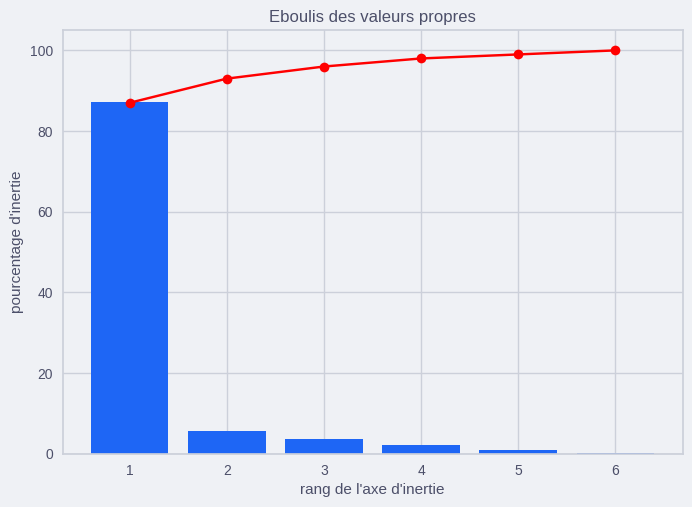

In [12]:
pca = c_PCA(df, columns,6)
pca.scale(StandardScaler())
pca.pca_evr()

Nous avons presque 100% de la variance expliquée par les 4 premiers axes. Nous allons donc nous contenter de les utiliser pour la suite de l'analyse.
On ne peut négliger le fait que 80% de la variance soit éxpliqué par le premier axe.

### Cercles Correlations

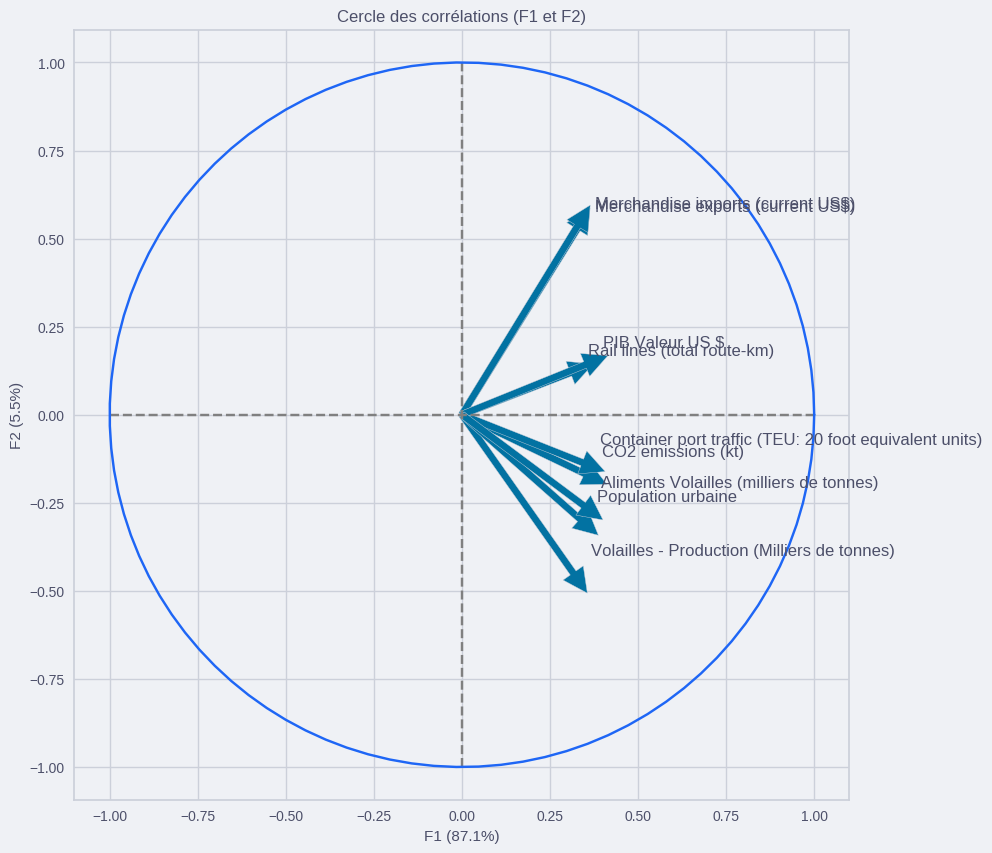

In [13]:
corr1, ax = plt.subplots(figsize=(10, 10))
pca.correlation_circle(ax, (0,1))

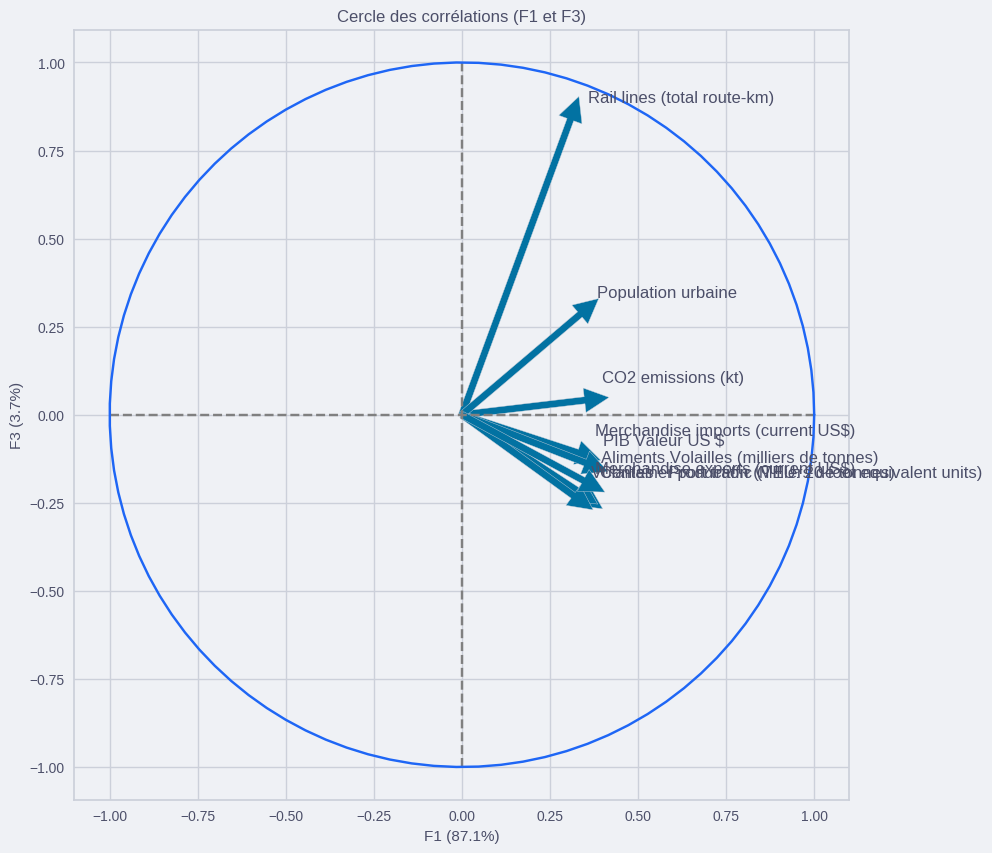

In [14]:
corr2, ax = plt.subplots(figsize=(10, 10))
pca.correlation_circle(ax, (0,2))

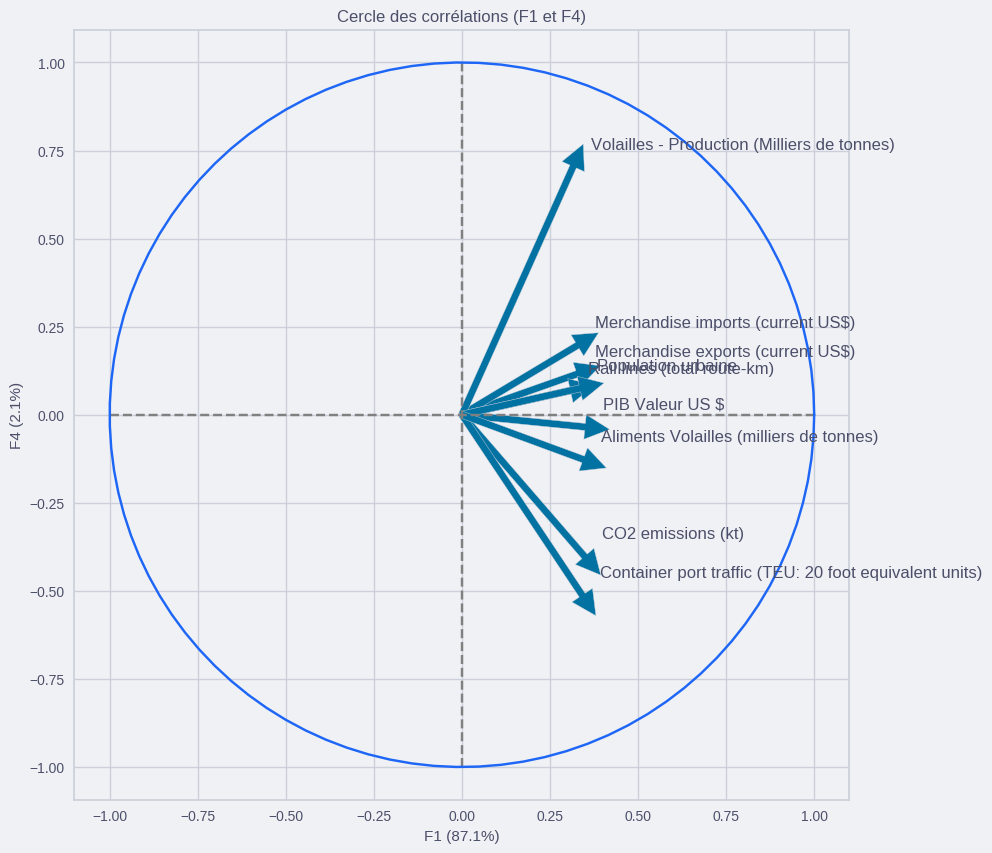

In [15]:
corr3, ax = plt.subplots(figsize=(10, 10))
pca.correlation_circle(ax, (0,3))

Les variables ne se départagent pas sur F1, ce qui nous empêche de bien pouvoir l'intérpréter correctement.

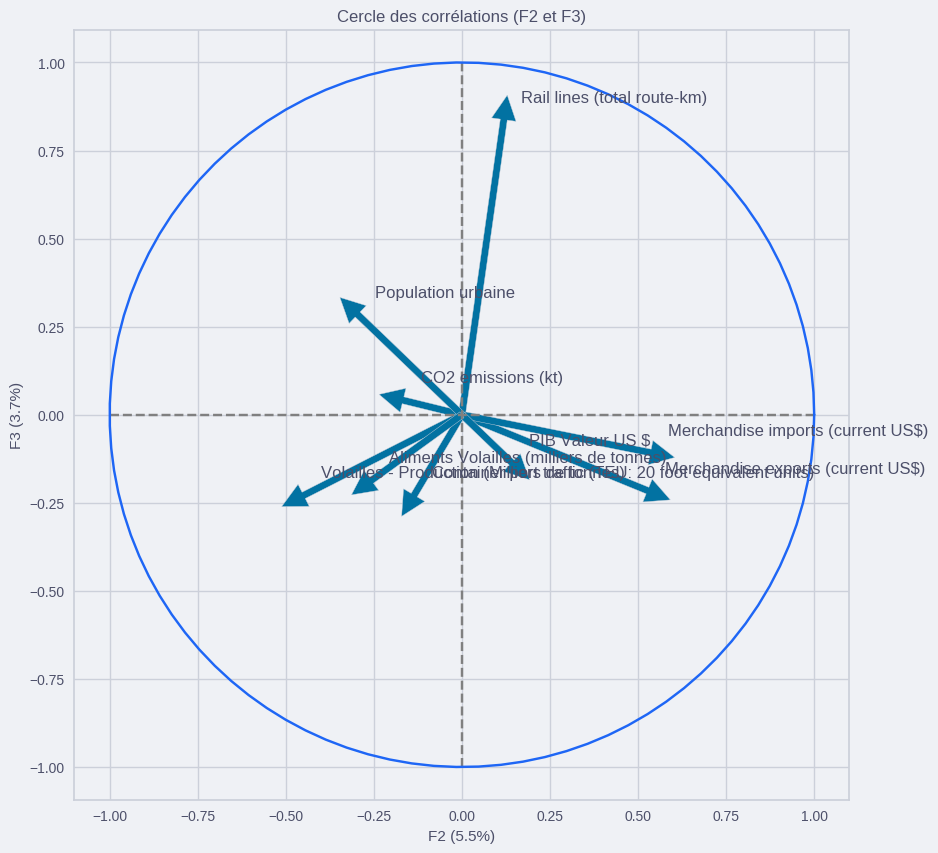

In [16]:
corr4, ax = plt.subplots(figsize=(10, 10))
pca.correlation_circle(ax, (1,2))

F3 est très fortement corrélé au réseau féroviaire. Sur F2, on peut remarquer les variables d'import/export d'un côté (~0.5) et mes variables ed production de volaiile de l'autre (~0.5).

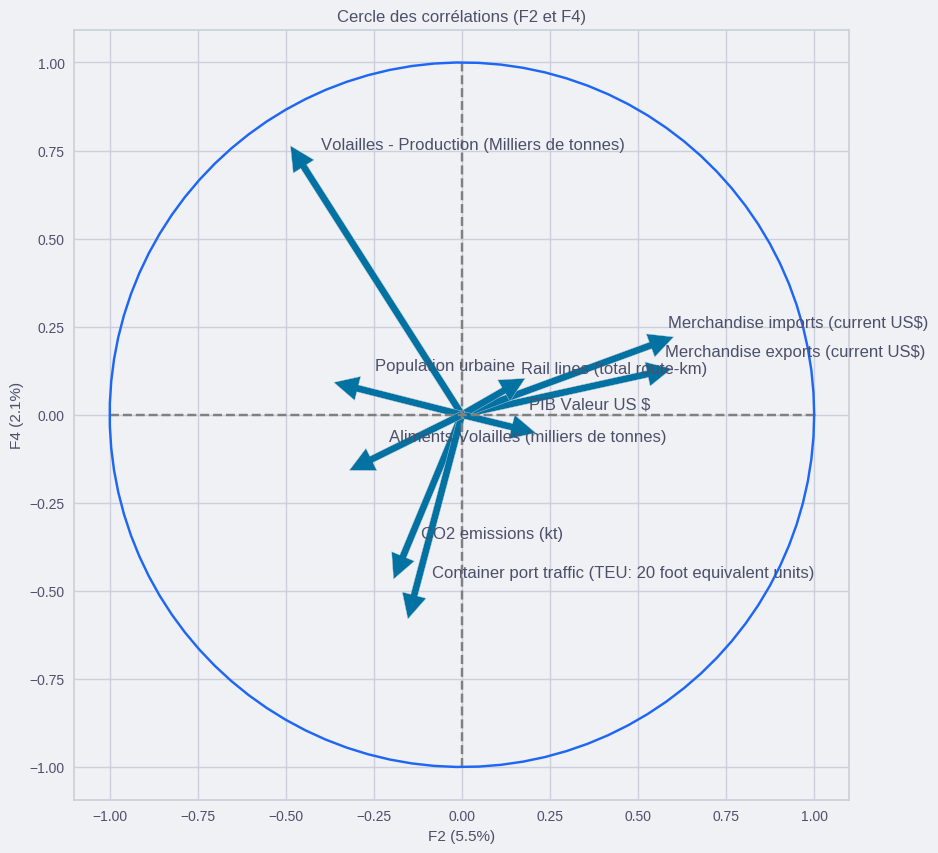

In [17]:
corr5, ax = plt.subplots(figsize=(10, 10))
pca.correlation_circle(ax, (1,3))

Sur F4, nous remarquons un lien fort avec la production de volaille. On y remarque aussi un lien avec le transport maritime et les emission de CO2

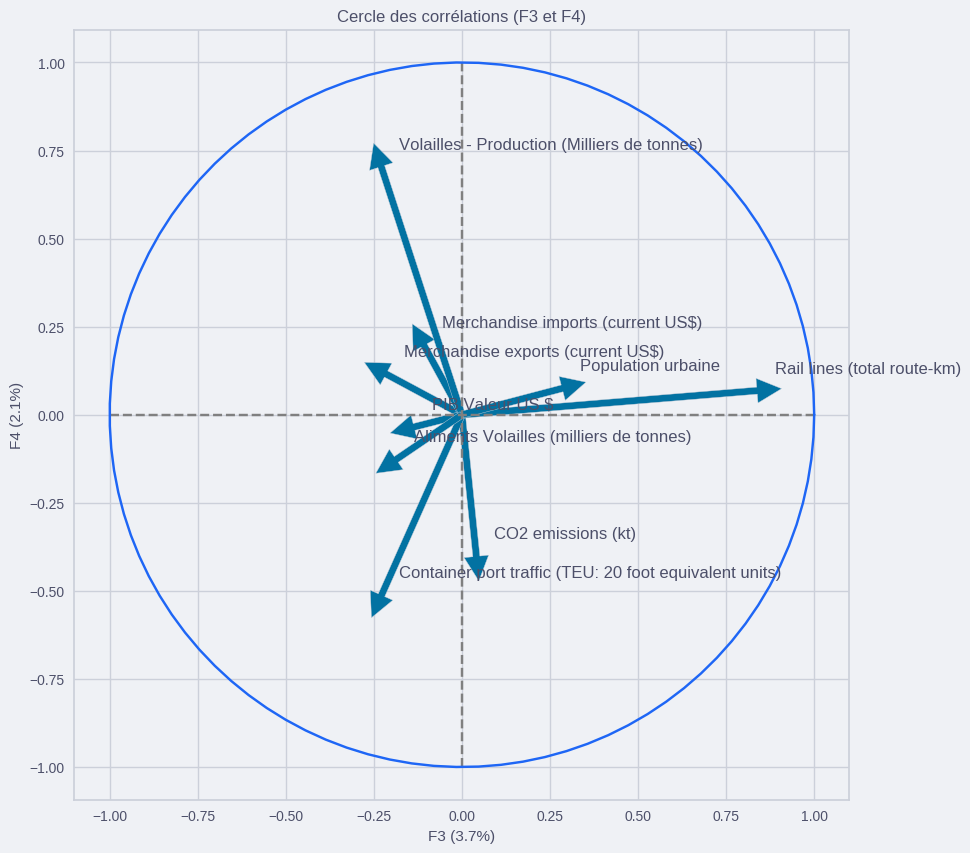

In [18]:
corr6, ax = plt.subplots(figsize=(10, 10))
pca.correlation_circle(ax, (2,3))

### Projection des individus

/tmp/ipykernel_690285/2549751352.py:144: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())


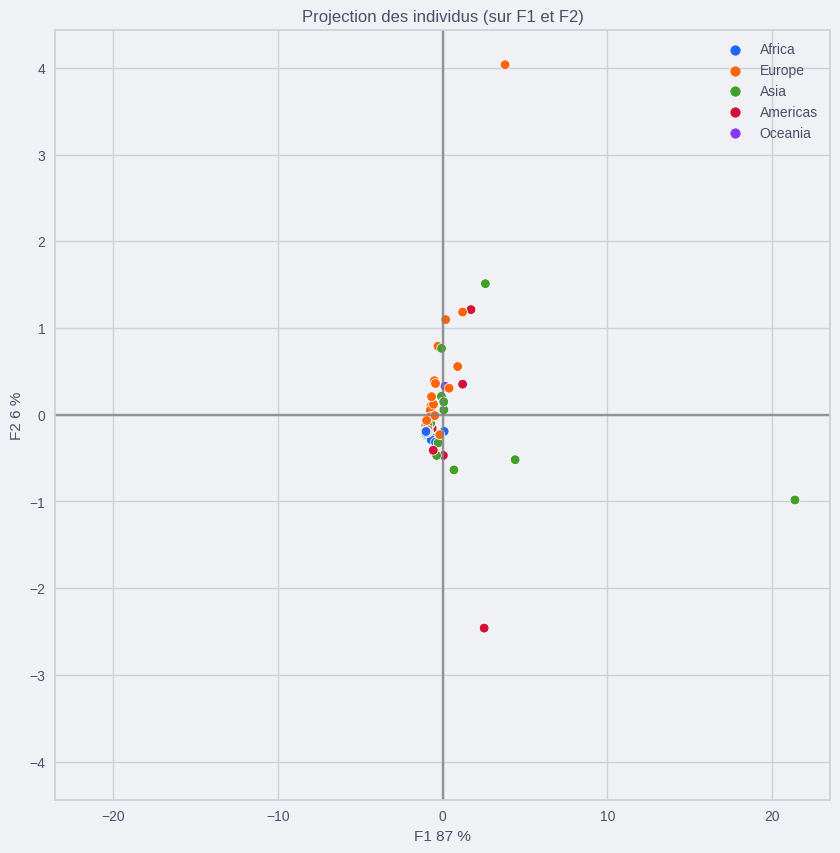

In [19]:
fp1, ax = plt.subplots(figsize=(10, 10))
pca.display_factorial_planesi(ax,(0,1), clusters=region)

/tmp/ipykernel_690285/2549751352.py:144: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())


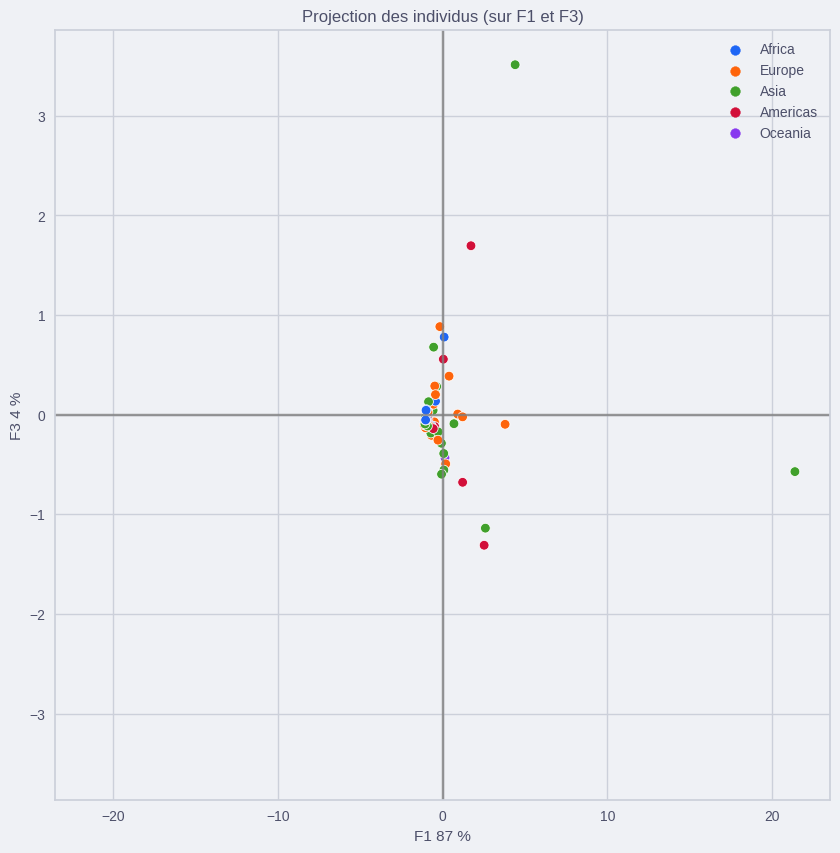

In [20]:
fp2, ax = plt.subplots(figsize=(10, 10))
pca.display_factorial_planesi(ax,(0,2),clusters=region)

/tmp/ipykernel_690285/2549751352.py:144: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())


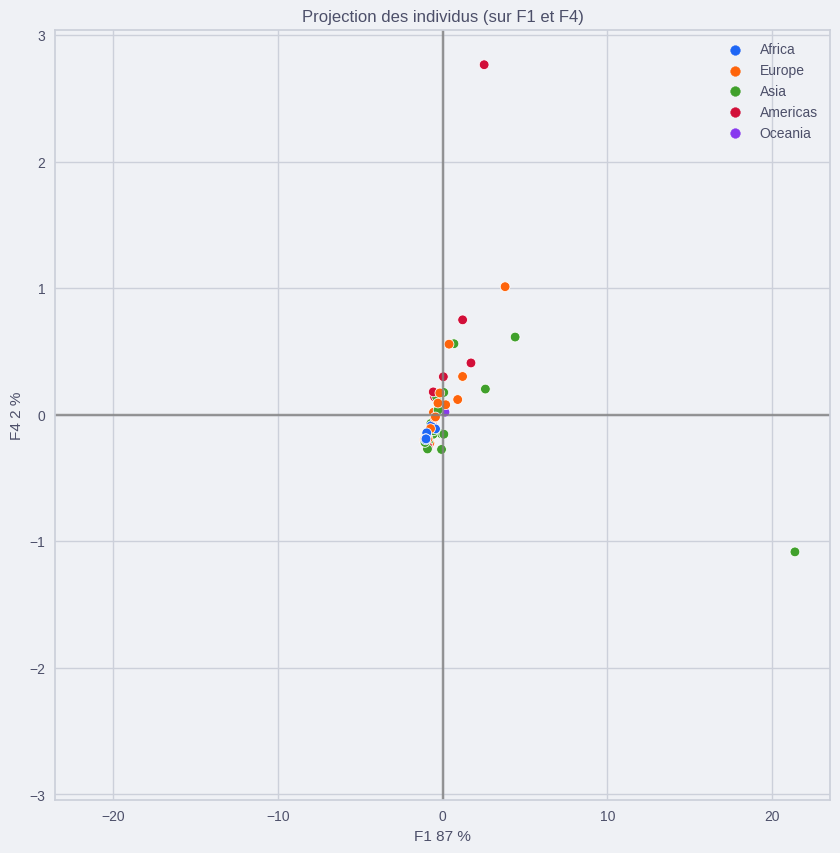

In [21]:
fp3, ax = plt.subplots(figsize=(10, 10))
pca.display_factorial_planesi(ax,(0,3),clusters=region)

Les variables sur F1 sont très proches les unes des autres. Il y a peu de variance sur cette dimension.

/tmp/ipykernel_690285/2549751352.py:144: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())


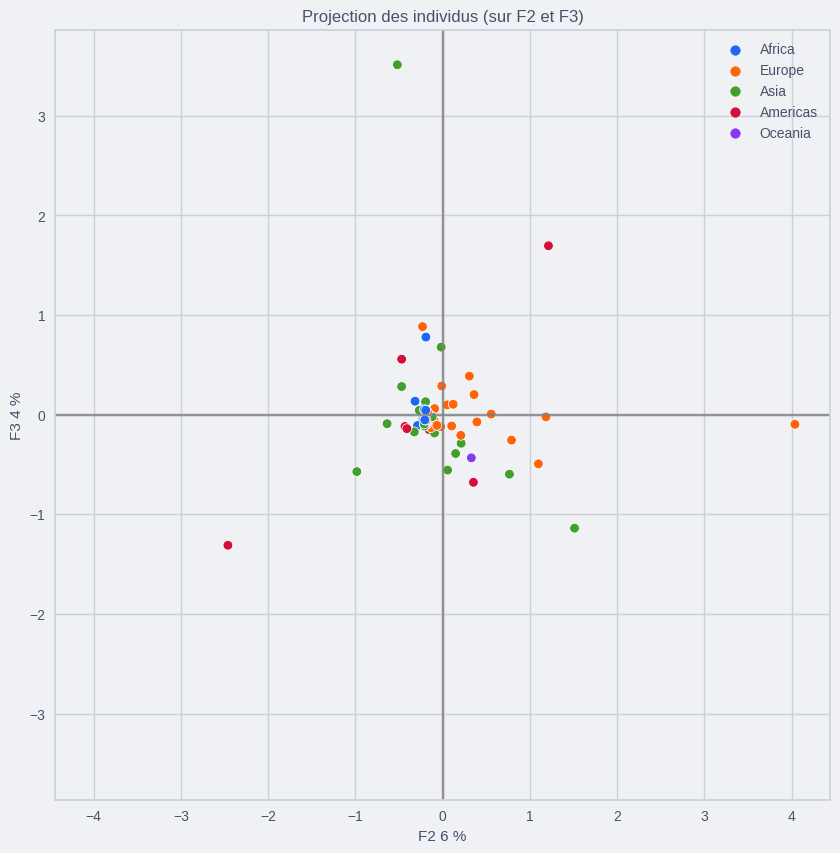

In [22]:
fp4, ax = plt.subplots(figsize=(10, 10))
pca.display_factorial_planesi(ax,(1,2),clusters=region)

/tmp/ipykernel_690285/2549751352.py:144: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())


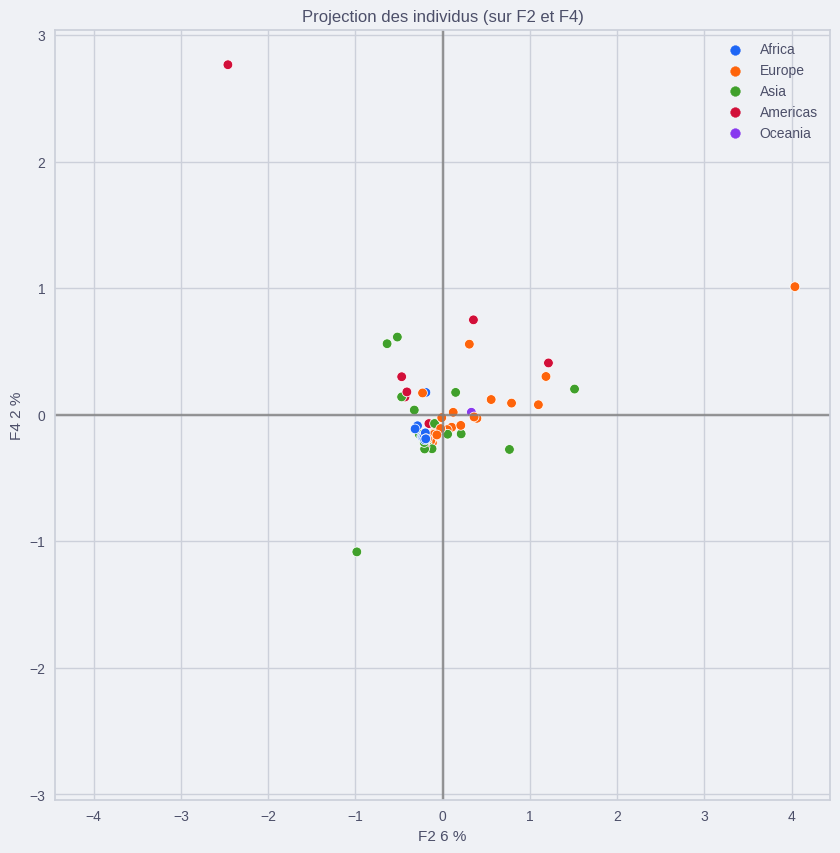

In [23]:
fp5, ax = plt.subplots(figsize=(10, 10))
pca.display_factorial_planesi(ax,(1,3),clusters=region)

/tmp/ipykernel_690285/2549751352.py:144: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())


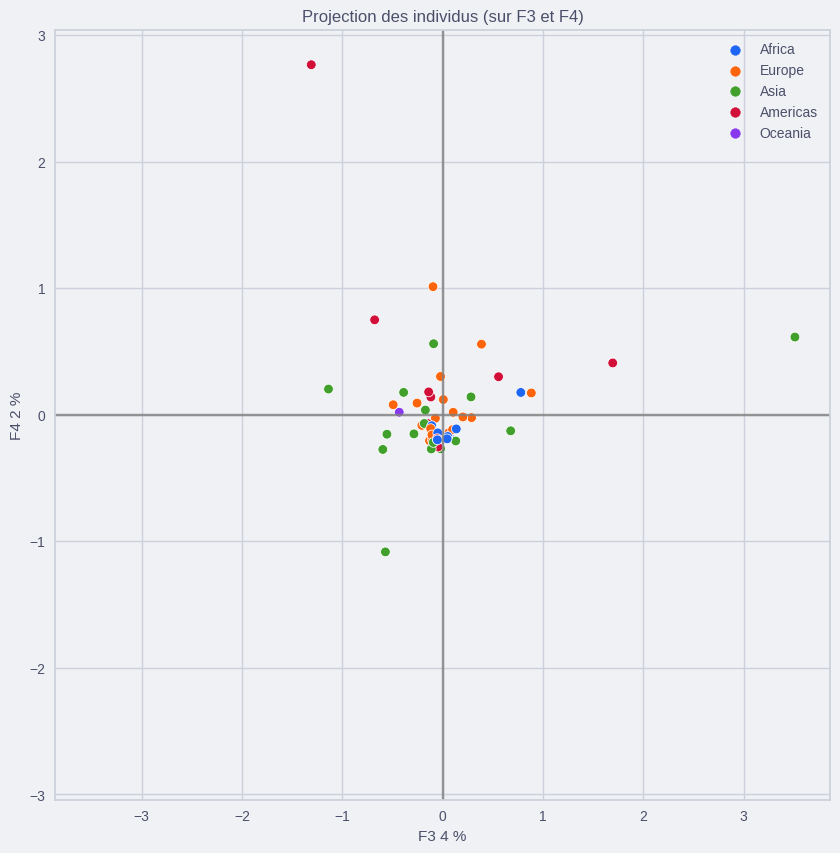

In [24]:
fp6, ax = plt.subplots(figsize=(10, 10))
pca.display_factorial_planesi(ax,(2,3),clusters=region)

Il y a bien plus de disparité sur les autres dimensions. Mais elles ne représentent qu'envion 20% de la variance. Tel quel, les données sont difficiles à interpréter

## CAH

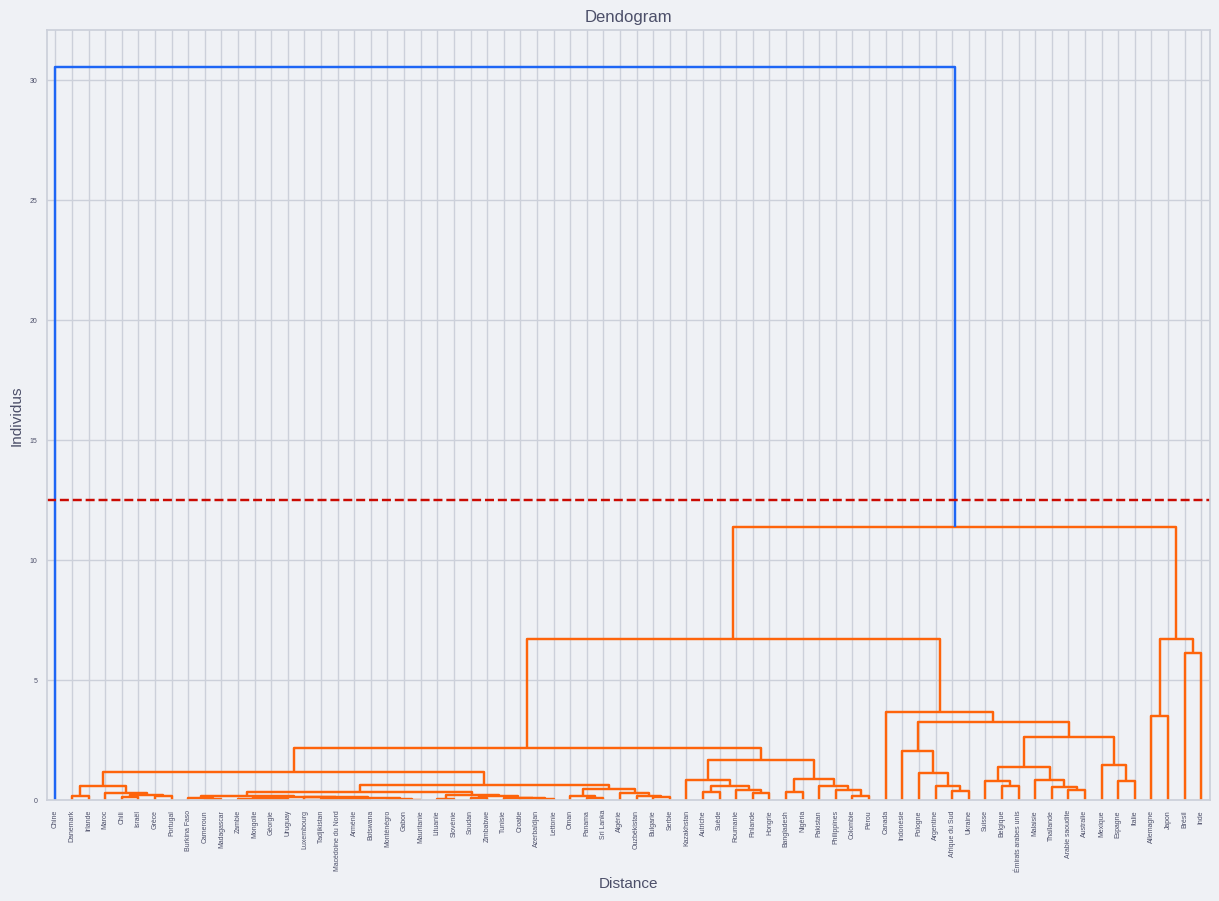

In [25]:
cah = CAH(df, columns)
cah.scale(StandardScaler())
fig, ax = plt.subplots(figsize=(15, 10))
cah.dendrogram(ax)
plt.axhline(y=12.5, color='r', linestyle='--')

Nous remarquons ici que la chine occupe à elle seule un cluster. Cela peut s'expliquer par le fait que la Chine est un pays très peuplé et est, en 2019, le deuxième plus gros producteur de poulet au monde.

On peut couper ce cluster en 2, la chine étant l'un de ses clusters.

In [26]:
df2 = df[~df.index.str.contains(r'Chine')]

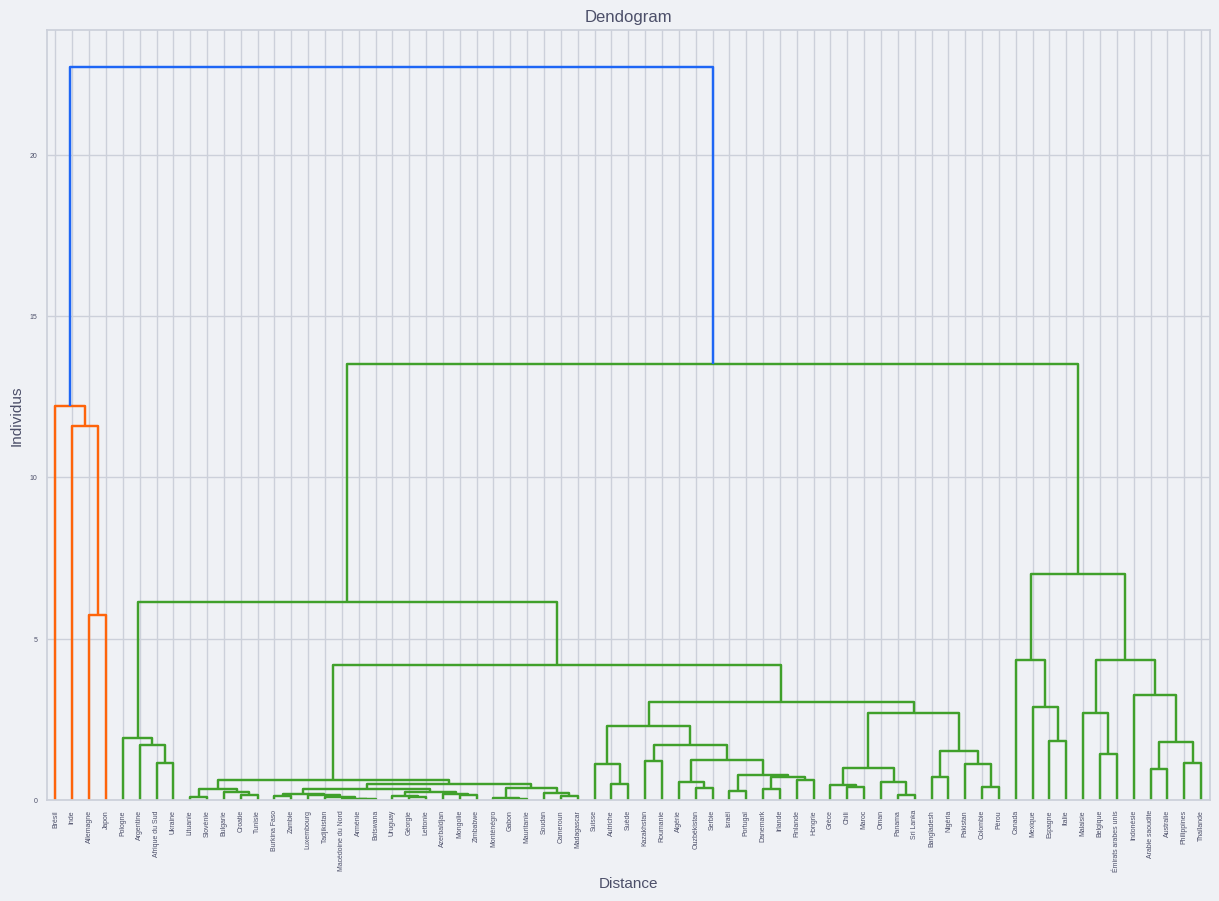

In [27]:
cah2 = CAH(df2, columns)
cah2.scale(StandardScaler())
fig, ax = plt.subplots(figsize=(15, 10))
cah2.dendrogram(ax)

Nous retrouvons ici un petit cluster composé du Japon de l'Allemagne, de l'Inde et du Brésil.
L'Inde est, au même titre que la Chine, un pays très peuplé. Le Brésil quant à lui est en 2019 le troisième plus gros producteur de poulet.
Il est plus difficile de trouver une explication pour le Japon est l'Allemagne : Etudions ces deux pays en les comparant aux autres.

In [28]:
df_jap_ger =  df.copy()
df_jap_ger['Japon/Allemagne'] = df.index.str.contains(r'Japon|Allemagne|Brésil')
df_jap_ger[df_jap_ger['Japon/Allemagne'] == True]

CO2 emissions (kt)  \
Zone                            
Allemagne            658693.5   
Brésil               434318.0   
Japon               1073645.3   

           Container port traffic (TEU: 20 foot equivalent units)  \
Zone                                                                
Allemagne                                         15029605.0        
Brésil                                            10704669.0        
Japon                                             23276482.0        

           Merchandise exports (current US$)  \
Zone                                           
Allemagne                      1489412000000   
Brésil                          221127000000   
Japon                           705564000000   

           Merchandise imports (current US$)  Rail lines (total route-km)  \
Zone                                                                        
Allemagne                      1233978000000                      33423.0   
Brésil                          193162000000                       2977.5   
Japon                           720957000000                       2977.5   

           PIB Valeur US $  Volailles - Production (Milliers de tonnes)  \
Zone                                                                      
Allemagne     3.888327e+06                                       1544.0   
Brésil        1.886015e+06                                      14094.0   
Japon         5.148782e+06                                       2298.0   

           Population urbaine  Aliments Volailles (milliers de tonnes)  \
Zone                                                                     
Allemagne           63787.507                                  12920.0   
Brésil             184407.548                                  47668.0   
Japon              116322.813                                  13040.0   

           Japon/Allemagne  
Zone                        
Allemagne             True  
Brésil                True  
Japon                 True

Text(0.5, 0.98, 'Boxplot by Japon/Allemagne/ for each features')

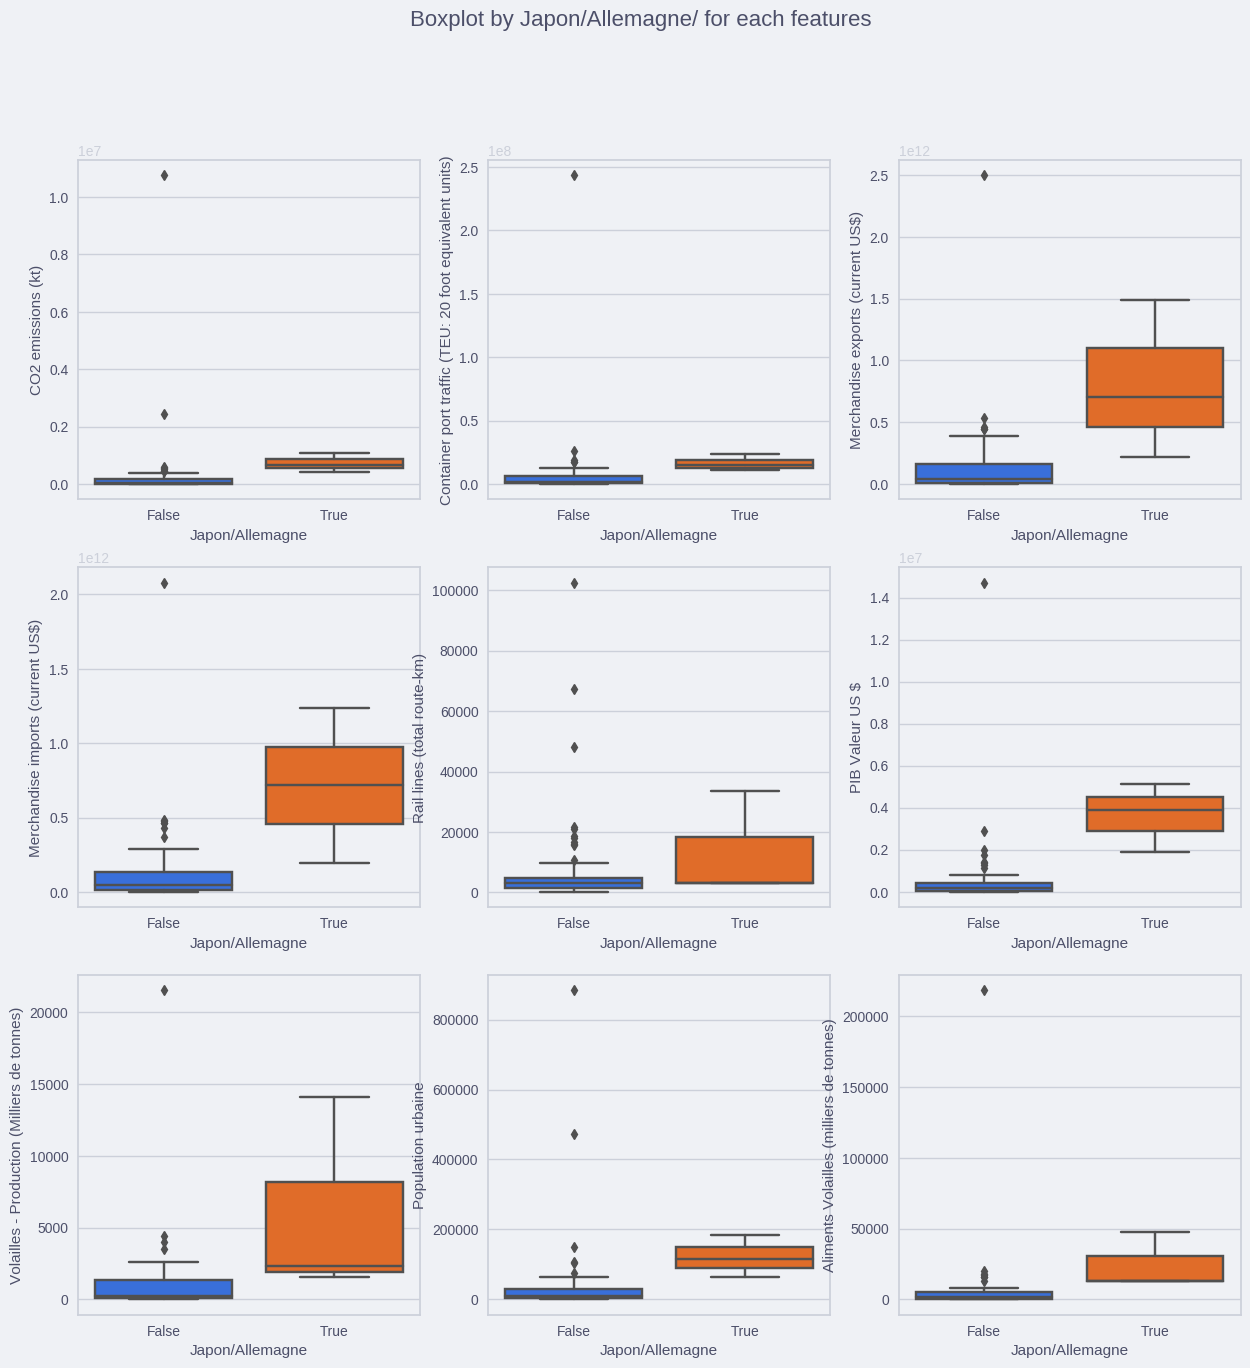

In [29]:
fig, ax = plt.subplots(3,3,figsize=(15, 15))
sns.boxplot(x="Japon/Allemagne", y="CO2 emissions (kt)", data=df_jap_ger, ax=ax[0,0])
sns.boxplot(x="Japon/Allemagne", y="Container port traffic (TEU: 20 foot equivalent units)", data=df_jap_ger, ax=ax[0,1])
sns.boxplot(x="Japon/Allemagne", y="Merchandise exports (current US$)", data=df_jap_ger, ax=ax[0,2])
sns.boxplot(x="Japon/Allemagne", y="Merchandise imports (current US$)", data=df_jap_ger, ax=ax[1,0])
sns.boxplot(x="Japon/Allemagne", y="Rail lines (total route-km)", data=df_jap_ger, ax=ax[1,1])
sns.boxplot(x="Japon/Allemagne", y="PIB Valeur US $", data=df_jap_ger, ax=ax[1,2])
sns.boxplot(x="Japon/Allemagne", y="Volailles - Production (Milliers de tonnes)", data=df_jap_ger, ax=ax[2,0])
sns.boxplot(x="Japon/Allemagne", y="Population urbaine", data=df_jap_ger, ax=ax[2,1])
sns.boxplot(x="Japon/Allemagne", y="Aliments Volailles (milliers de tonnes)", data=df_jap_ger, ax=ax[2,2])
fig.suptitle('Boxplot by Japon/Allemagne/ for each features', fontsize=16)

Nous pouvons remarquer que le Japon et L'Allemagne sont dans bien des cas dans la zone des outliers. Nous allons donc les retirer de l'analyse. Ils nécessiteraient une analyse à eux seul.

## Kmeans

Pour le K-means, nous allons simplement étudier le résultat sans le retrait du Japon, de l'Allemagne, de la Chine, de l'Inde et du Brésil. Nous relancerons une analyse ultérieurement (ACP/CAH/Kmeans) sans ces pays.

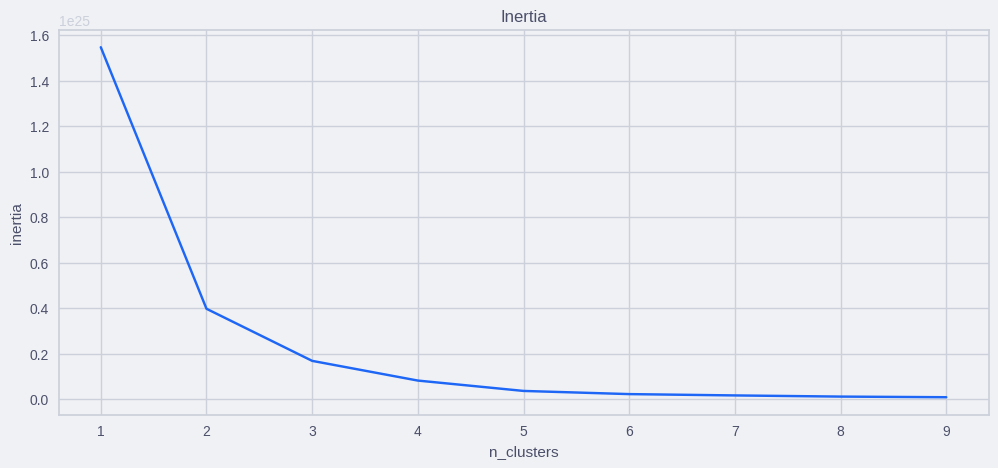

In [30]:
km = kmeans(df, columns)
fig, ax = plt.subplots(figsize=(12, 5))
km.plot_inertia(ax)


For n_clusters = 2, silhouette score is 0.894)
For n_clusters = 3, silhouette score is 0.723)
For n_clusters = 4, silhouette score is 0.715)
For n_clusters = 5, silhouette score is 0.688)


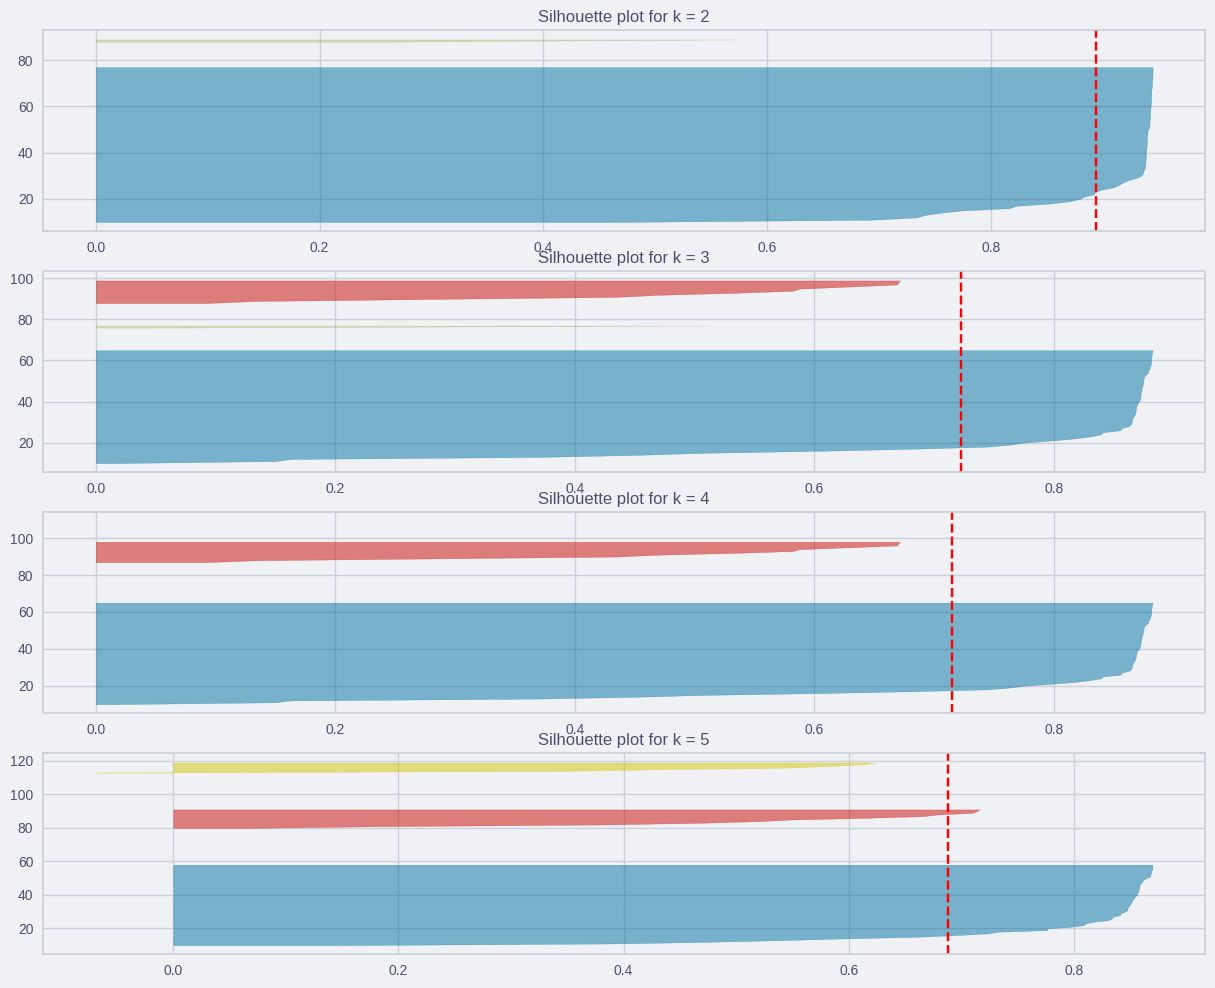

In [31]:
fig, ax = plt.subplots(4,1,figsize=(15, 12))
km.plot_silhouette(ax,[2,3,4,5])

Si l'on s'intéresse graphique de silhouette, on remarque que pour K=2 les clusters sont assez mal définit : Nous avons un énorme cluster et un autre qui est composé de très peu de pays. Nous pouvons déjà penser à des pays comme la Chine, le Brésil ou l'Inde.

In [32]:
km.kmean_choose(2)
km.clusters

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0], dtype=int32)

In [33]:
df['cluster']=km.clusters
columns.append('cluster')

### Clusters

In [34]:
df.columns

Index(['CO2 emissions (kt)',
       'Container port traffic (TEU: 20 foot equivalent units)',
       'Merchandise exports (current US$)',
       'Merchandise imports (current US$)', 'Rail lines (total route-km)',
       'PIB Valeur US $', 'Volailles - Production (Milliers de tonnes)',
       'Population urbaine', 'Aliments Volailles (milliers de tonnes)',
       'cluster'],
      dtype='object')

In [35]:
km_df = df[columns]

Text(0.5, 0.98, 'Boxplot by clusters for each features')

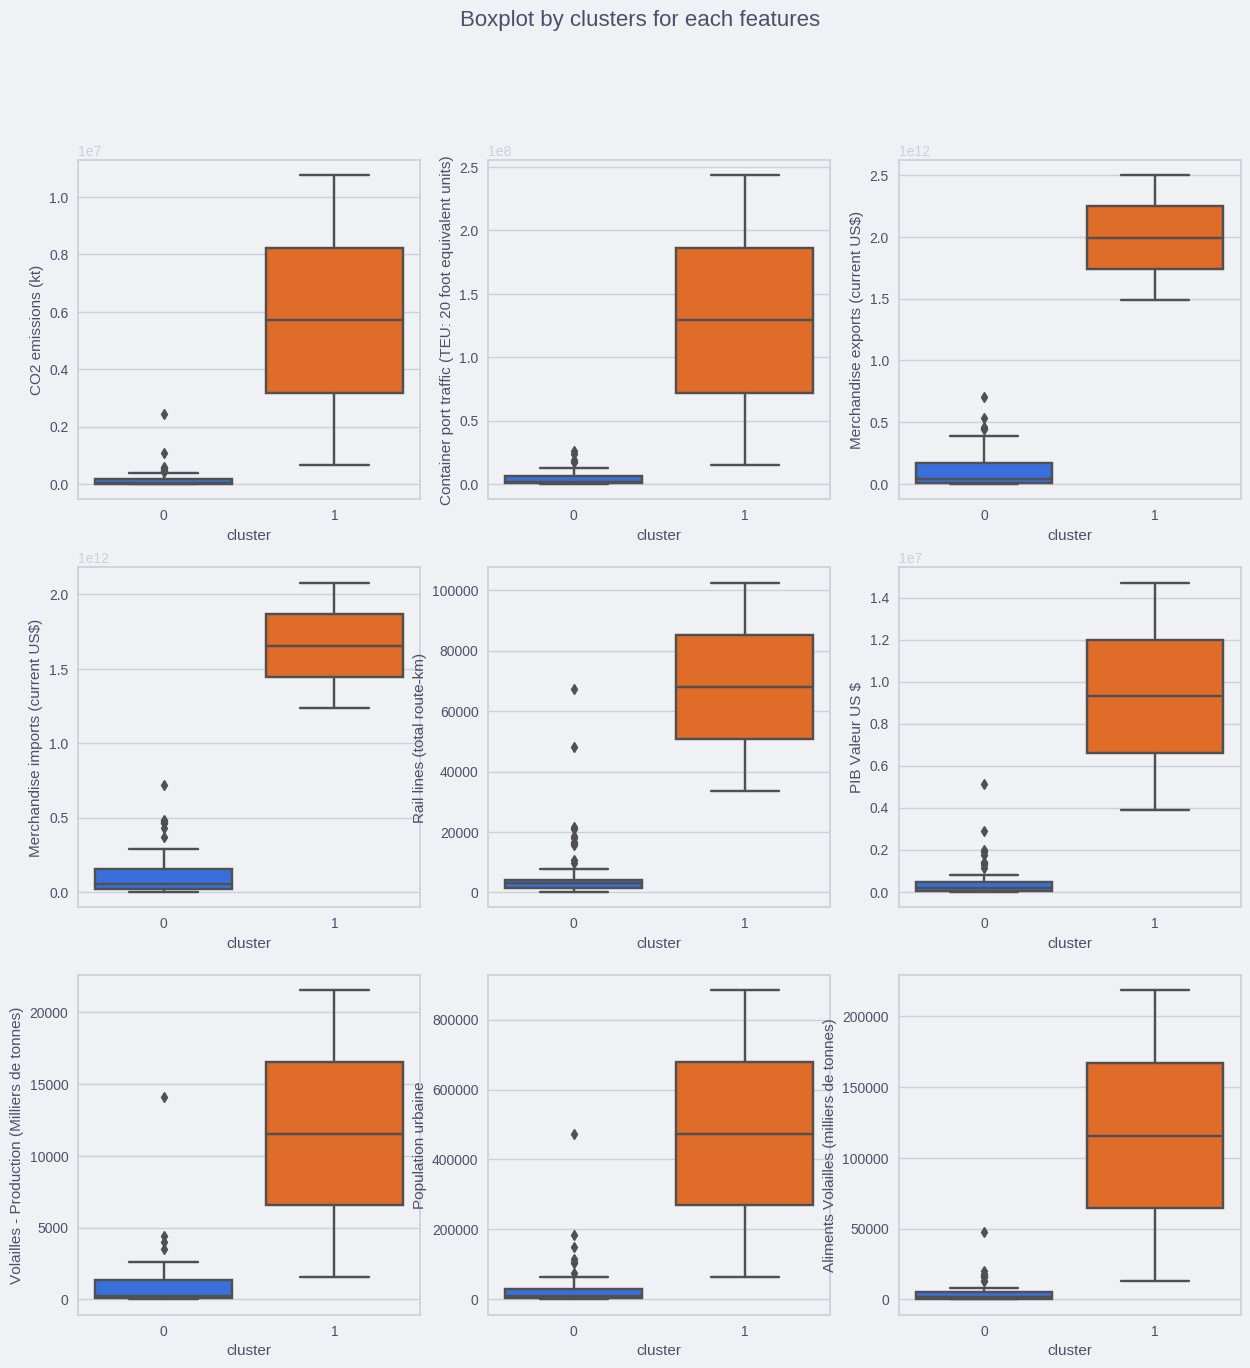

In [36]:
# box plot by clusters for each feature
fig, ax = plt.subplots(3,3,figsize=(15, 15))
sns.boxplot(x="cluster", y="CO2 emissions (kt)", data=km_df, ax=ax[0,0])
sns.boxplot(x="cluster", y="Container port traffic (TEU: 20 foot equivalent units)", data=km_df, ax=ax[0,1])
sns.boxplot(x="cluster", y="Merchandise exports (current US$)", data=km_df, ax=ax[0,2])
sns.boxplot(x="cluster", y="Merchandise imports (current US$)", data=km_df, ax=ax[1,0])
sns.boxplot(x="cluster", y="Rail lines (total route-km)", data=km_df, ax=ax[1,1])
sns.boxplot(x="cluster", y="PIB Valeur US $", data=km_df, ax=ax[1,2])
sns.boxplot(x="cluster", y="Volailles - Production (Milliers de tonnes)", data=km_df, ax=ax[2,0])
sns.boxplot(x="cluster", y="Population urbaine", data=km_df, ax=ax[2,1])
sns.boxplot(x="cluster", y="Aliments Volailles (milliers de tonnes)", data=km_df, ax=ax[2,2])
fig.suptitle('Boxplot by clusters for each features', fontsize=16)

In [37]:
cluster0 = km_df[km_df['cluster']==0]
cluster0

CO2 emissions (kt)  \
Zone                                      
Afrique du Sud                 446626.0   
Algérie                        170582.4   
Arabie saoudite                526770.3   
Argentine                      168162.0   
Arménie                          6195.6   
...                                 ...   
Ukraine                        174599.9   
Uruguay                          6806.7   
Zambie                           7615.7   
Zimbabwe                        10185.3   
Émirats arabes unis            185645.7   

                     Container port traffic (TEU: 20 foot equivalent units)  \
Zone                                                                          
Afrique du Sud                                               4529034.0        
Algérie                                                      1793990.0        
Arabie saoudite                                              8905621.0        
Argentine                                                    1833964.0        
Arménie                                                      1229081.0        
...                                                                ...        
Ukraine                                                      1007273.0        
Uruguay                                                       749562.0        
Zambie                                                       1229081.0        
Zimbabwe                                                     1229081.0        
Émirats arabes unis                                         18802000.0        

                     Merchandise exports (current US$)  \
Zone                                                     
Afrique du Sud                             90016000000   
Algérie                                    35312000000   
Arabie saoudite                           261603000000   
Argentine                                  65116000000   
Arménie                                     2640000000   
...                                                ...   
Ukraine                                    50054000000   
Uruguay                                     7680000000   
Zambie                                      7039000000   
Zimbabwe                                    4269000000   
Émirats arabes unis                       389428000000   

                     Merchandise imports (current US$)  \
Zone                                                     
Afrique du Sud                            107539000000   
Algérie                                    44632000000   
Arabie saoudite                           153163000000   
Argentine                                  49124000000   
Arménie                                     5514000000   
...                                                ...   
Ukraine                                    60800000000   
Uruguay                                     8246000000   
Zambie                                      7173000000   
Zimbabwe                                    4817000000   
Émirats arabes unis                       288447000000   

                     Rail lines (total route-km)  PIB Valeur US $  \
Zone                                                                
Afrique du Sud                          20953.00    351430.991183   
Algérie                                  4020.25    171158.234285   
Arabie saoudite                          2977.50    792966.838190   
Argentine                               17866.00    445445.254556   
Arménie                                   698.40     13619.290546   
...                                          ...              ...   
Ukraine                                 21625.90    153929.552493   
Uruguay                                  1498.00     61231.193299   
Zambie                                   1248.00     23309.720448   
Zimbabwe                                 3120.00     21935.075306   
Émirats arabes unis                       261.00    417215.559513   

                     Vola

In [38]:
cluster1 = km_df[km_df['cluster']==1]
cluster1

CO2 emissions (kt)  \
Zone                            
Allemagne            658693.5   
Chine              10762824.0   

           Container port traffic (TEU: 20 foot equivalent units)  \
Zone                                                                
Allemagne                                         15029605.0        
Chine                                            243560000.0        

           Merchandise exports (current US$)  \
Zone                                           
Allemagne                      1489412000000   
Chine                          2499457000000   

           Merchandise imports (current US$)  Rail lines (total route-km)  \
Zone                                                                        
Allemagne                      1233978000000                      33423.0   
Chine                          2078386000000                     102462.0   

           PIB Valeur US $  Volailles - Production (Milliers de tonnes)  \
Zone                                                                      
Allemagne     3.888327e+06                                       1544.0   
Chine         1.470083e+07                                      21518.0   

           Population urbaine  Aliments Volailles (milliers de tonnes)  \
Zone                                                                     
Allemagne           63787.507                                  12920.0   
Chine              883204.937                                 218290.0   

           cluster  
Zone                
Allemagne        1  
Chine            1

/tmp/ipykernel_690285/2549751352.py:144: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())


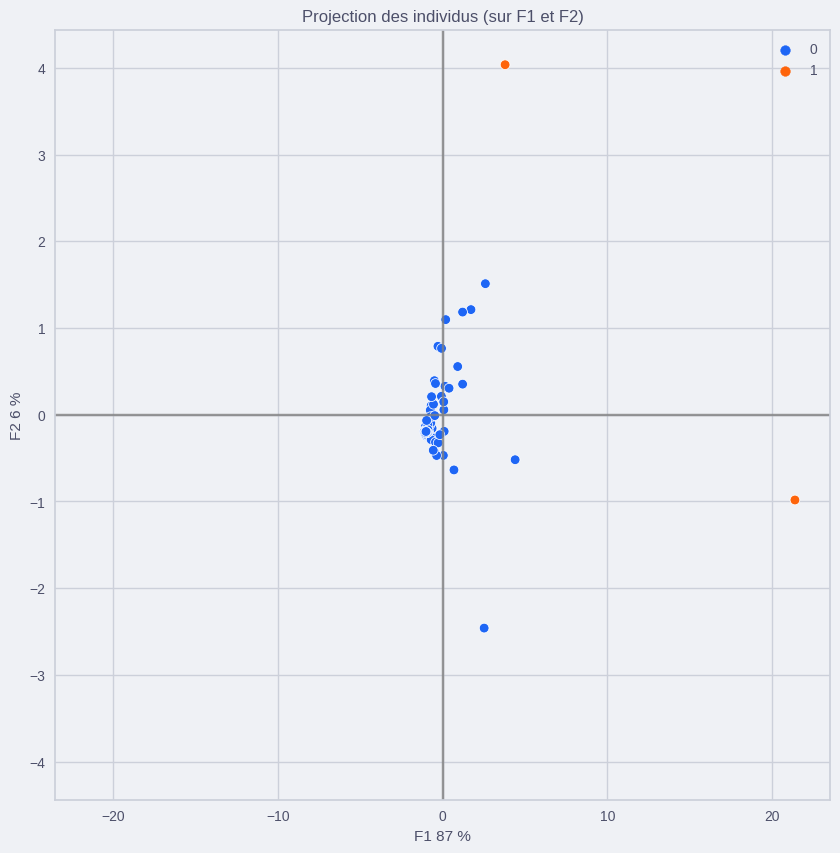

In [39]:
fp1, ax = plt.subplots(figsize=(10, 10))
pca.display_factorial_planesi(ax,(0,1), clusters=km.clusters)

## Conclusions
Le jeu de donnée est bien trop impacté par des "poids lourds" comme la Chine. Nous allons relancer notre analyse en prenant soin de transformer nos données avec le logarithme décimal. 

# Analyse np.log

In [40]:
df = df_og.copy()

In [41]:
region = df['region'].tolist()
df = df.drop(columns=['region'])
columns = df.columns.tolist()
df.head()

CO2 emissions (kt)  \
Zone                                  
Afrique du Sud             446626.0   
Algérie                    170582.4   
Allemagne                  658693.5   
Arabie saoudite            526770.3   
Argentine                  168162.0   

                 Container port traffic (TEU: 20 foot equivalent units)  \
Zone                                                                      
Afrique du Sud                                           4529034.0        
Algérie                                                  1793990.0        
Allemagne                                               15029605.0        
Arabie saoudite                                          8905621.0        
Argentine                                                1833964.0        

                 Merchandise exports (current US$)  \
Zone                                                 
Afrique du Sud                         90016000000   
Algérie                                35312000000   
Allemagne                            1489412000000   
Arabie saoudite                       261603000000   
Argentine                              65116000000   

                 Merchandise imports (current US$)  \
Zone                                                 
Afrique du Sud                        107539000000   
Algérie                                44632000000   
Allemagne                            1233978000000   
Arabie saoudite                       153163000000   
Argentine                              49124000000   

                 Rail lines (total route-km)  PIB Valeur US $  \
Zone                                                            
Afrique du Sud                      20953.00     3.514310e+05   
Algérie                              4020.25     1.711582e+05   
Allemagne                           33423.00     3.888327e+06   
Arabie saoudite                      2977.50     7.929668e+05   
Argentine                           17866.00     4.454453e+05   

                 Volailles - Production (Milliers de tonnes)  \
Zone                                                           
Afrique du Sud                                        1816.0   
Algérie                                                285.0   
Allemagne                                             1544.0   
Arabie saoudite                                        800.0   
Argentine                                             2249.0   

                 Population urbaine  Aliments Volailles (milliers de tonnes)  
Zone                                                                          
Afrique du Sud            38820.239                                   5721.0  
Algérie                   31236.431                                   4152.0  
Allemagne                 63787.507                                  12920.0  
Arabie saoudite           28700.362                                   2511.0  
Argentine                 41489.566                                  16050.0

In [42]:
df_log = df.applymap(lambda x: np.log(x+1))
df = df_log

## PCA

Explained variance ratio:  [76.77  9.52  5.19  3.79  2.5   1.3 ]
Cumulative explained variance ratio:  [77. 86. 91. 95. 98. 99.]


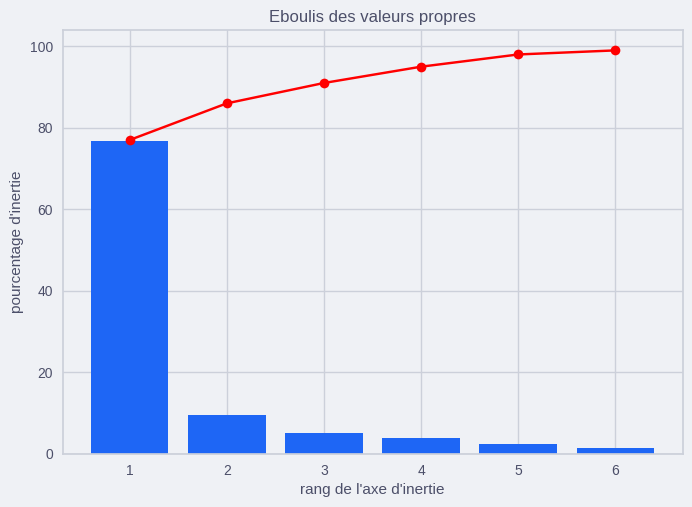

In [43]:
pca2 = c_PCA(df, columns,6)
pca2.scale(RobustScaler())
pca2.pca_evr()

Nous pouvons déjà remarquer un impact sur notre PCA. En effet, la variance expliquée par l'Axe 1 a diminué d'environ 10%.

### Cercles Correlations

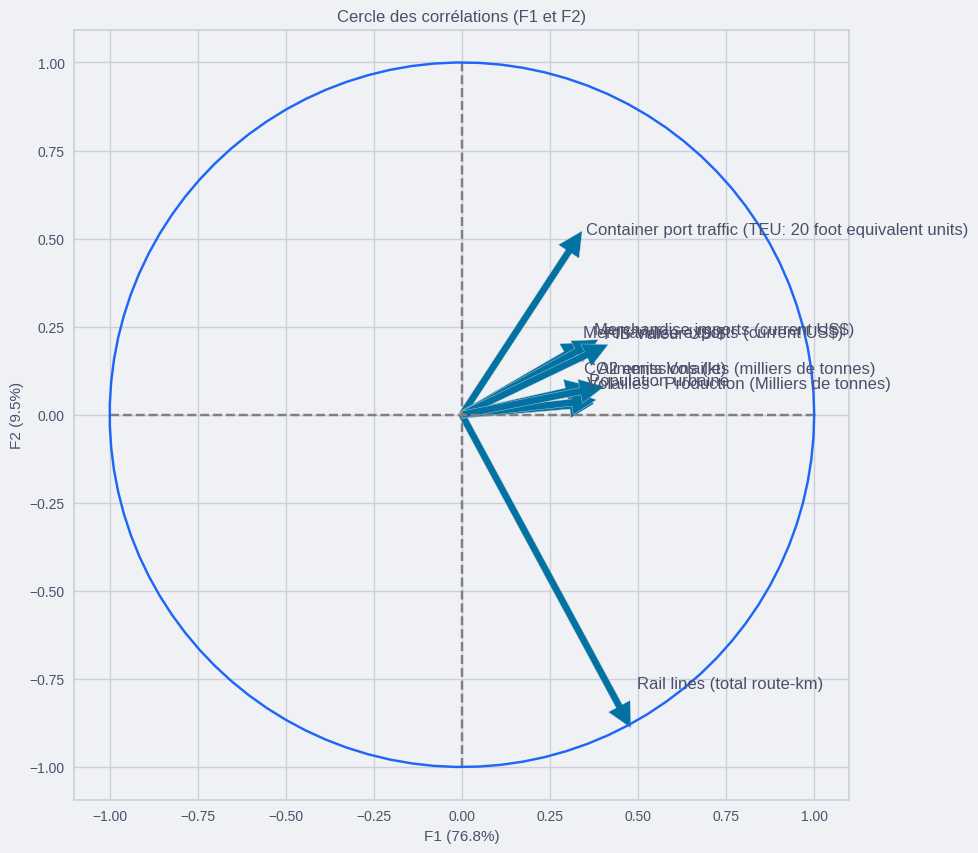

In [44]:
corr1, ax = plt.subplots(figsize=(10, 10))
pca2.correlation_circle(ax, (0,1))

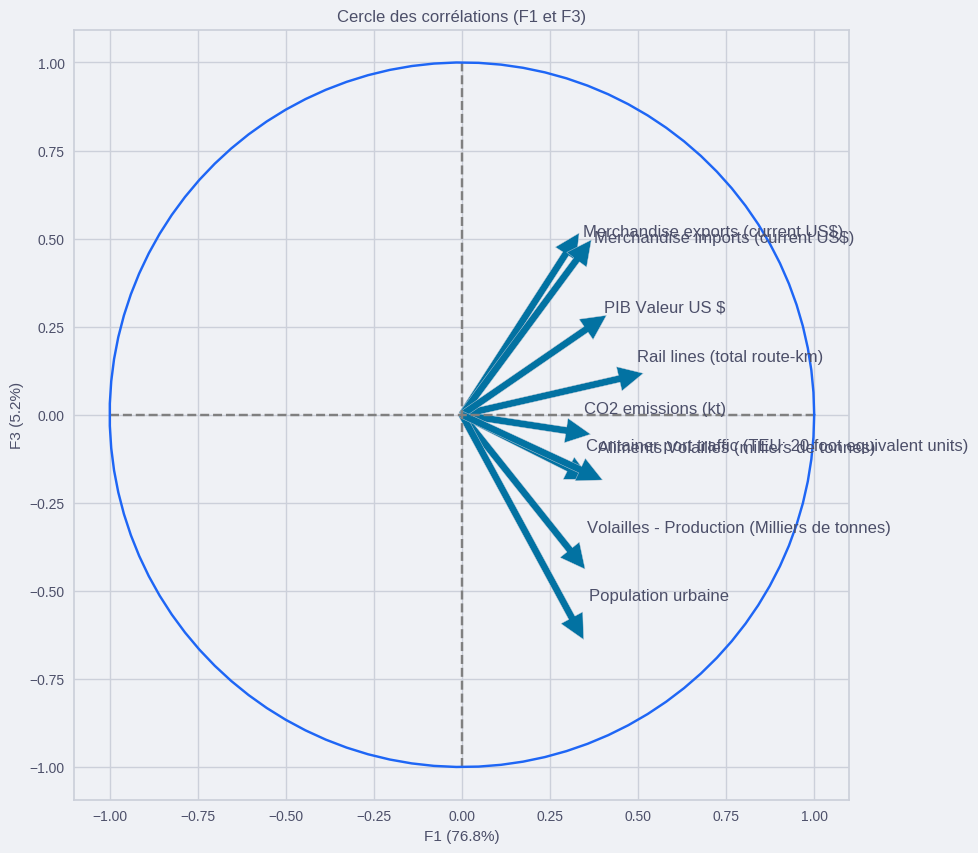

In [45]:
corr2, ax = plt.subplots(figsize=(10, 10))
pca2.correlation_circle(ax, (0,2))

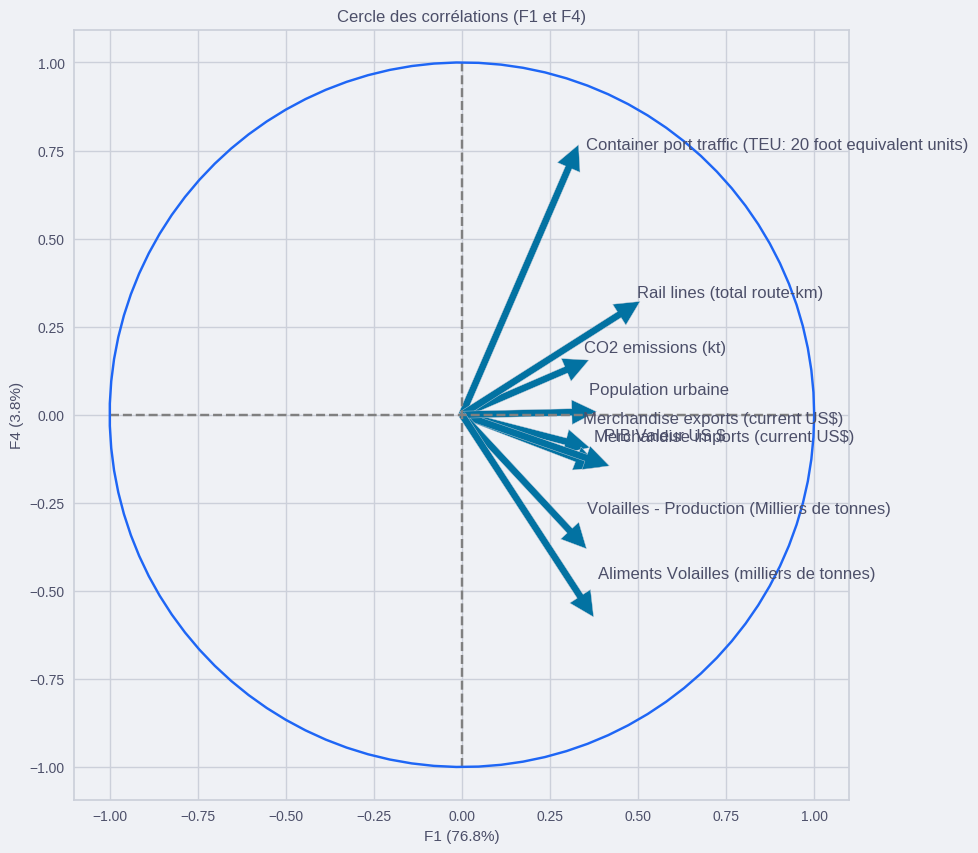

In [46]:
corr3, ax = plt.subplots(figsize=(10, 10))
pca2.correlation_circle(ax, (0,3))

La conclusion sur F1 est similaire à l'analyse précédente : Les variables ne se départagent pas sur F1, ce qui nous empêche de bien pouvoir l'intérpréter correctement.

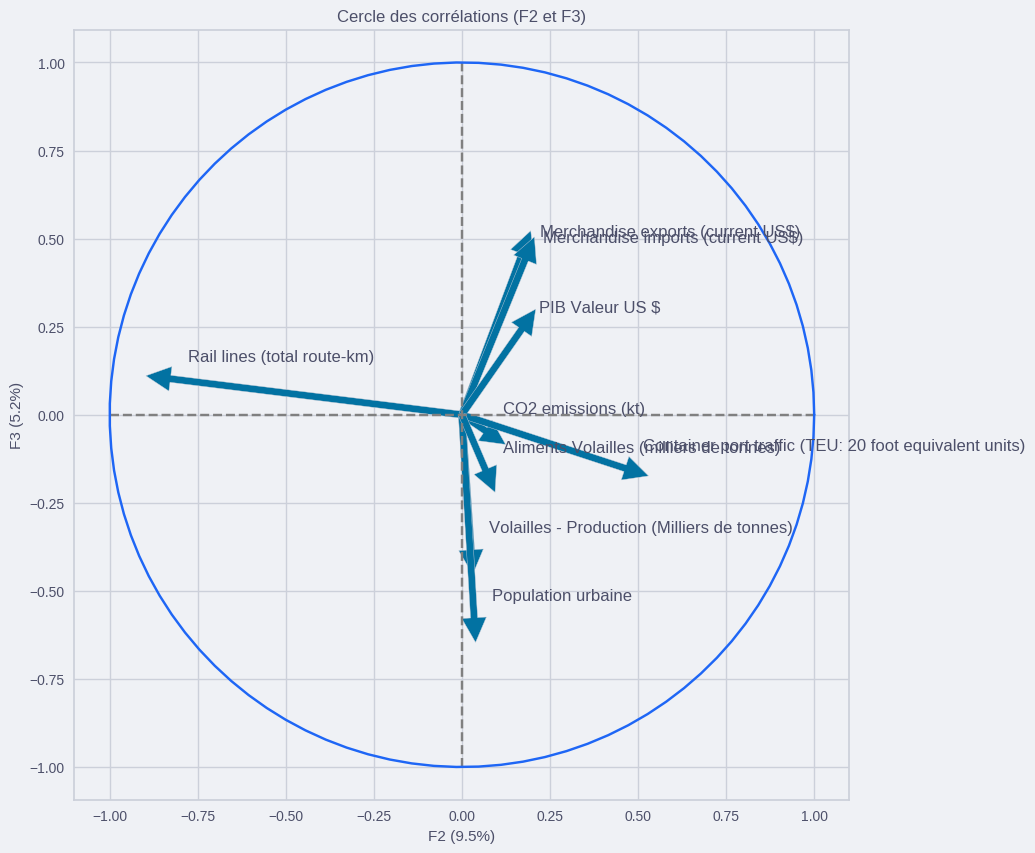

In [47]:
corr4, ax = plt.subplots(figsize=(10, 10))
pca2.correlation_circle(ax, (1,2))

F2 montre ici une corrélation modérée de la population urbain sur cette dimension. Nous retrouvons sur F3 notre corrélation positive sur le réseau féroviaire et notre corrélation négative sur les émissions de CO2. 

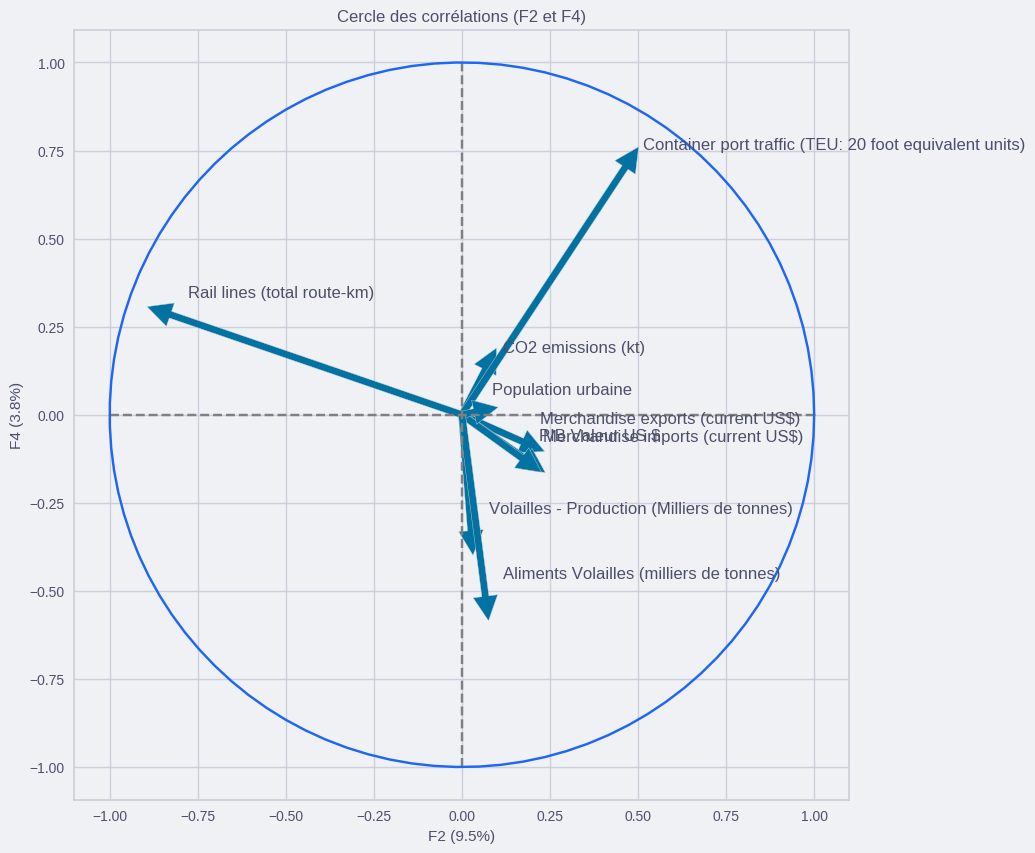

In [48]:
corr5, ax = plt.subplots(figsize=(10, 10))
pca2.correlation_circle(ax, (1,3))

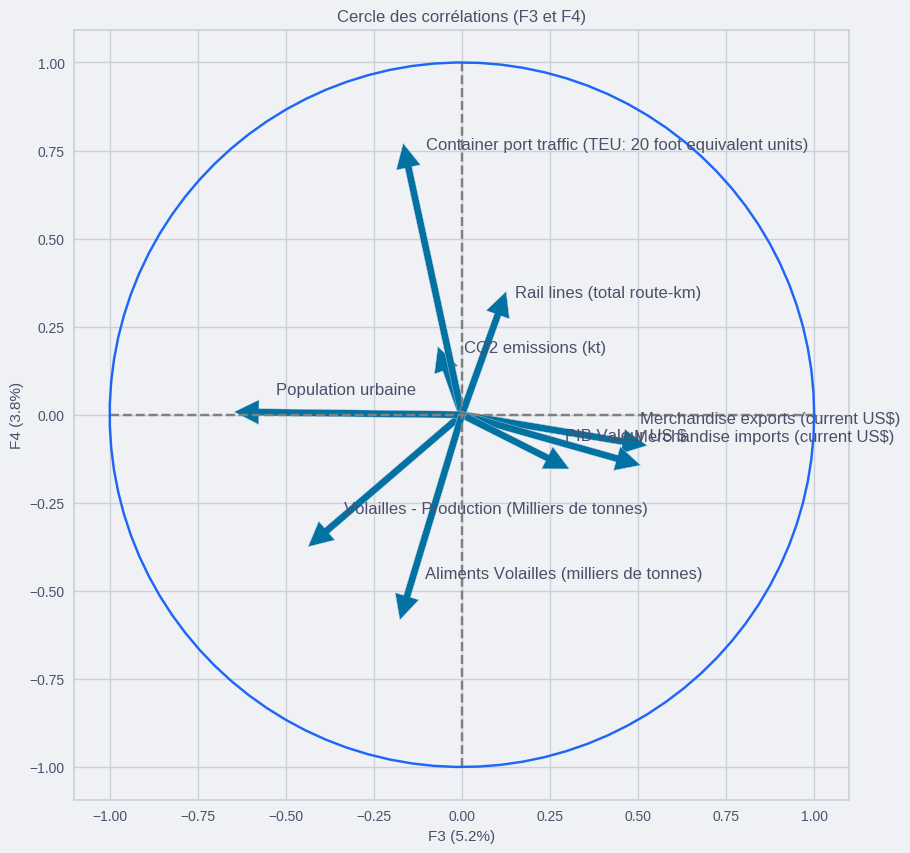

In [49]:
corr6, ax = plt.subplots(figsize=(10, 10))
pca2.correlation_circle(ax, (2,3))

### Projection des individus

/tmp/ipykernel_690285/2549751352.py:144: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())


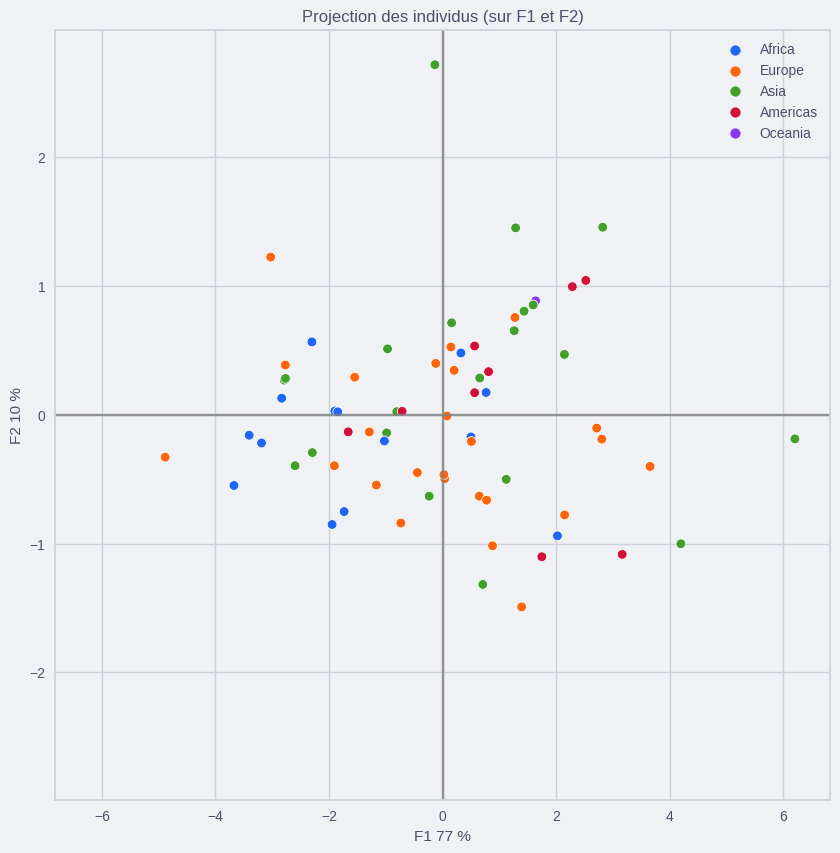

In [50]:
fp1, ax = plt.subplots(figsize=(10, 10))
pca2.display_factorial_planesi(ax,(0,1), clusters=region)

/tmp/ipykernel_690285/2549751352.py:144: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())


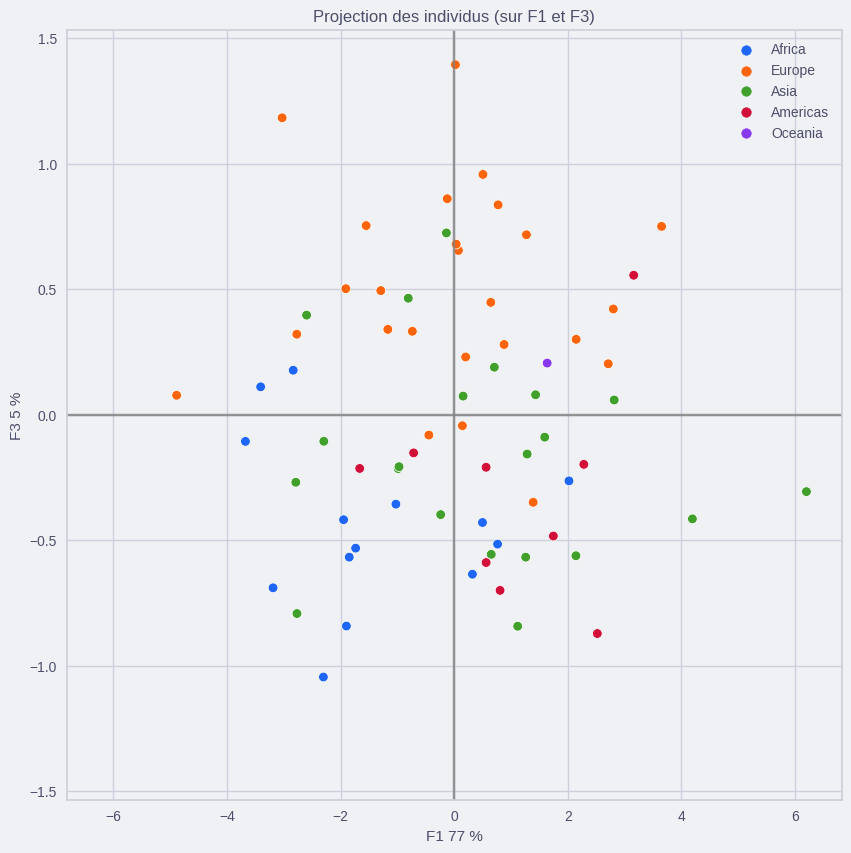

In [51]:
fp2, ax = plt.subplots(figsize=(10, 10))
pca2.display_factorial_planesi(ax,(0,2),clusters=region)

/tmp/ipykernel_690285/2549751352.py:144: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())


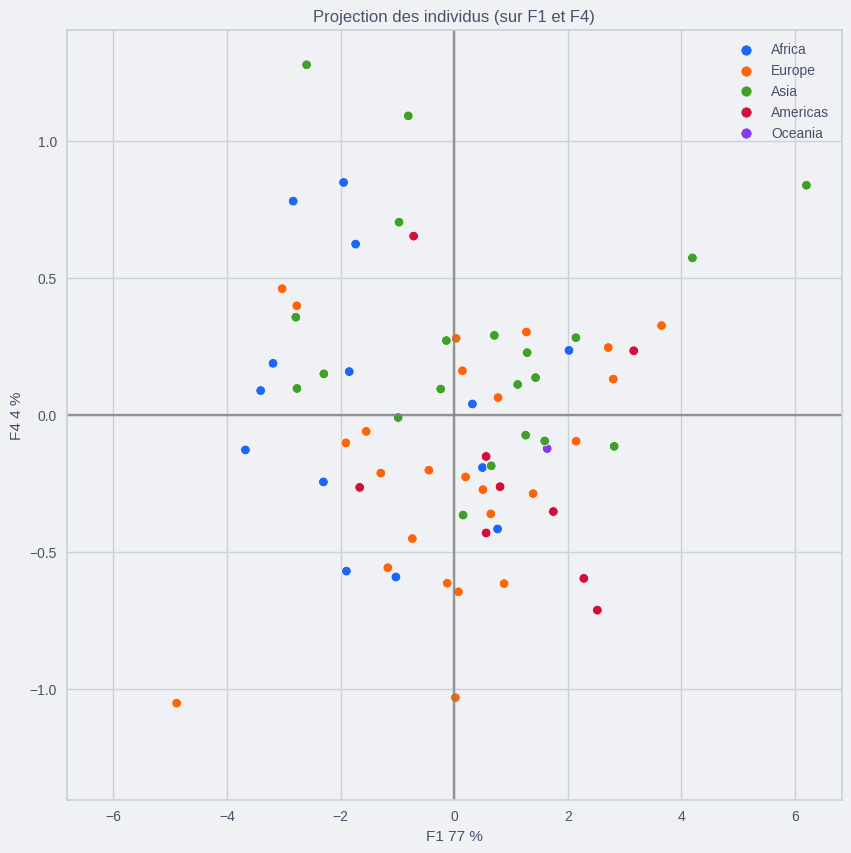

In [52]:
fp3, ax = plt.subplots(figsize=(10, 10))
pca2.display_factorial_planesi(ax,(0,3),clusters=region)

Nous remarquons ici que les individus ne sont plus "tassés" comme lors de notre analyse précédente. Nous avons une meilleure répartition des individus sur les dimensions.

/tmp/ipykernel_690285/2549751352.py:144: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())


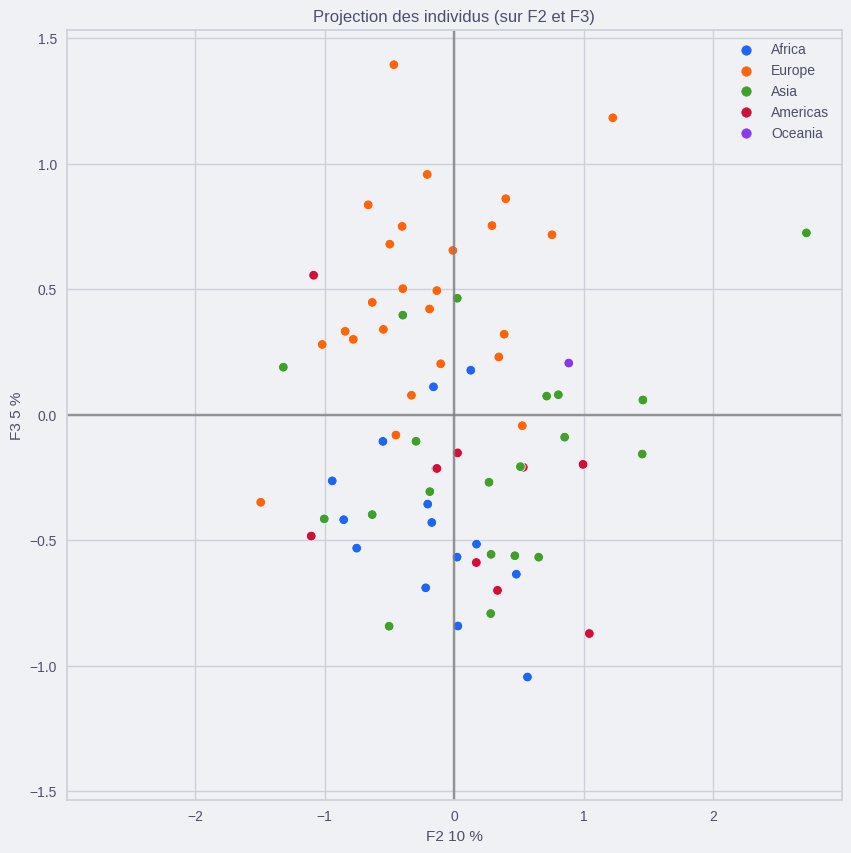

In [53]:
fp4, ax = plt.subplots(figsize=(10, 10))
pca2.display_factorial_planesi(ax,(1,2),clusters=region)

/tmp/ipykernel_690285/2549751352.py:144: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())


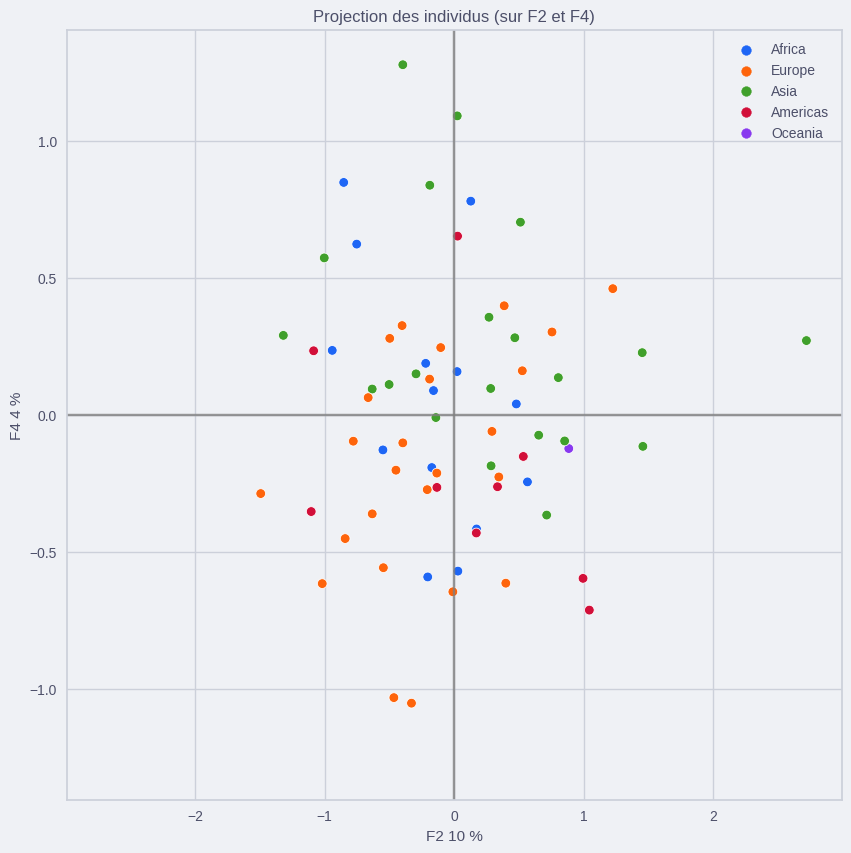

In [54]:
fp5, ax = plt.subplots(figsize=(10, 10))
pca2.display_factorial_planesi(ax,(1,3),clusters=region)

/tmp/ipykernel_690285/2549751352.py:144: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())


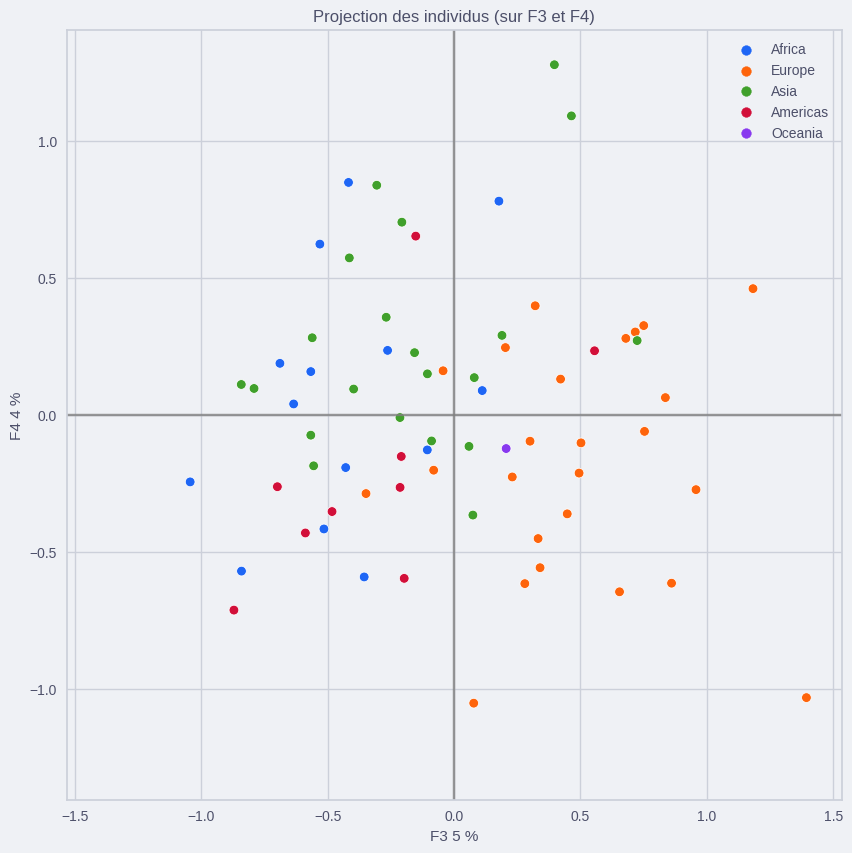

In [55]:
fp6, ax = plt.subplots(figsize=(10, 10))
pca2.display_factorial_planesi(ax,(2,3),clusters=region)

## CAH

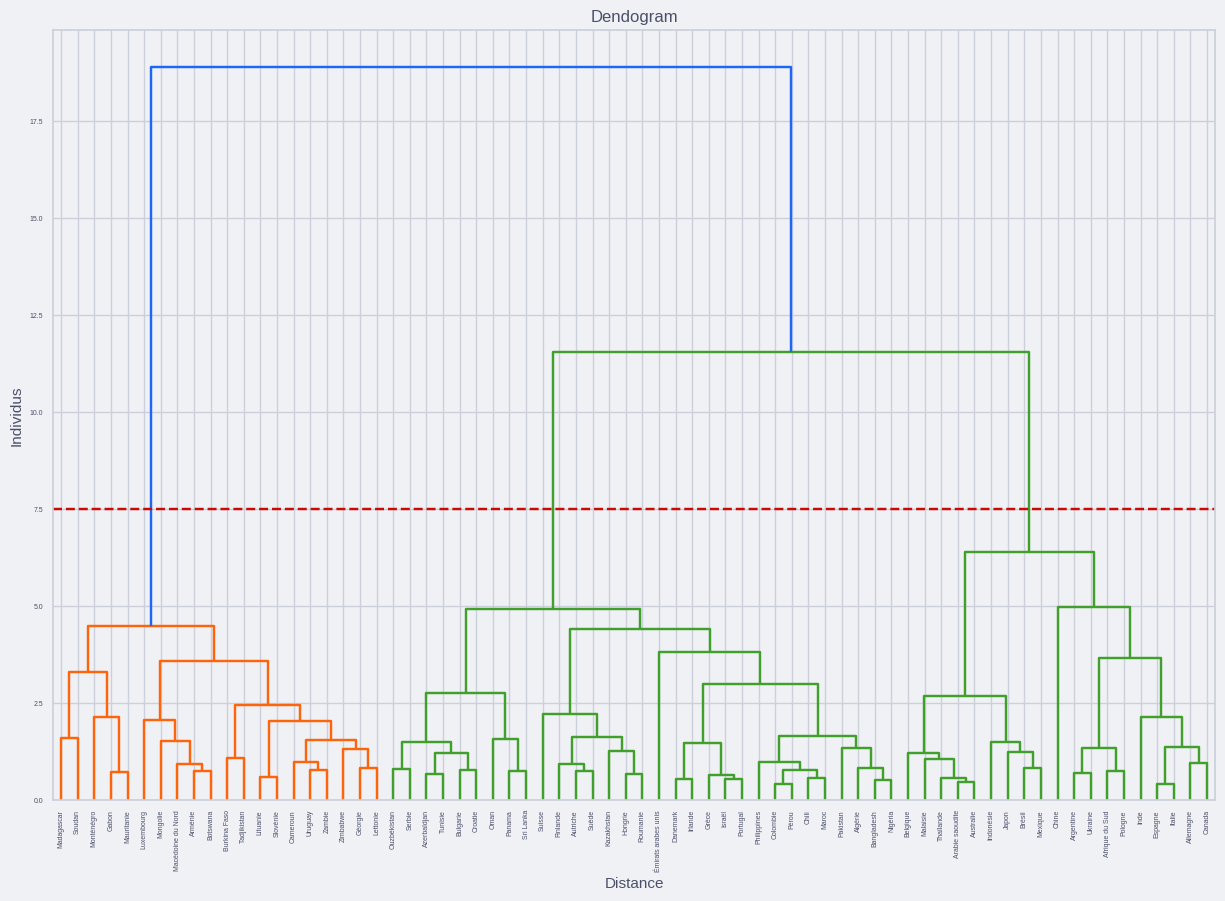

In [56]:
cah3 = CAH(df, columns)
cah3.scale(RobustScaler())
fig, ax = plt.subplots(figsize=(15, 10))
cah3.dendrogram(ax)
plt.axhline(y=7.5, color='r', linestyle='--')

Nous pouvons ici observer un groupe de trois cluster lorsque l'on coupe le dendogramme à 7.5

## Kmeans

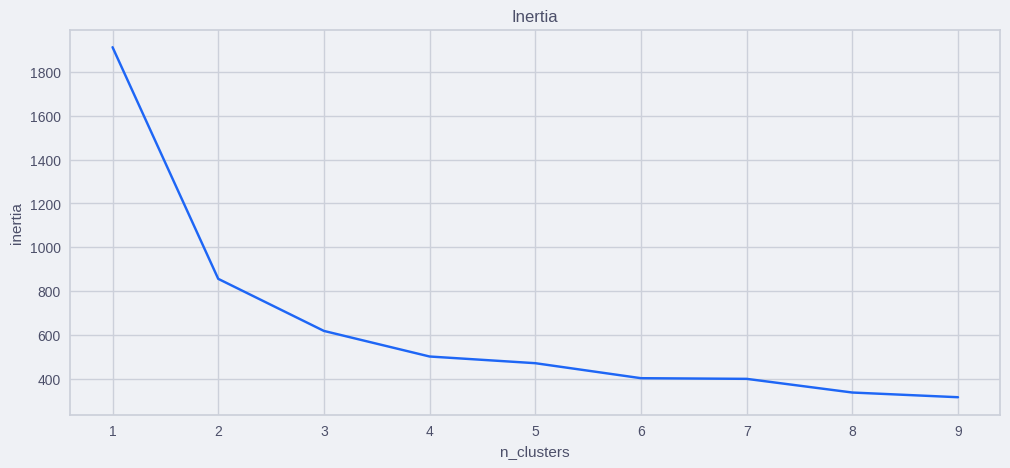

In [57]:
km = kmeans(df, columns)
fig, ax = plt.subplots(figsize=(12, 5))
km.plot_inertia(ax)


For n_clusters = 2, silhouette score is 0.445)
For n_clusters = 3, silhouette score is 0.325)
For n_clusters = 4, silhouette score is 0.295)
For n_clusters = 5, silhouette score is 0.276)
For n_clusters = 6, silhouette score is 0.203)
For n_clusters = 7, silhouette score is 0.218)
For n_clusters = 8, silhouette score is 0.240)
For n_clusters = 9, silhouette score is 0.189)
For n_clusters = 10, silhouette score is 0.202)


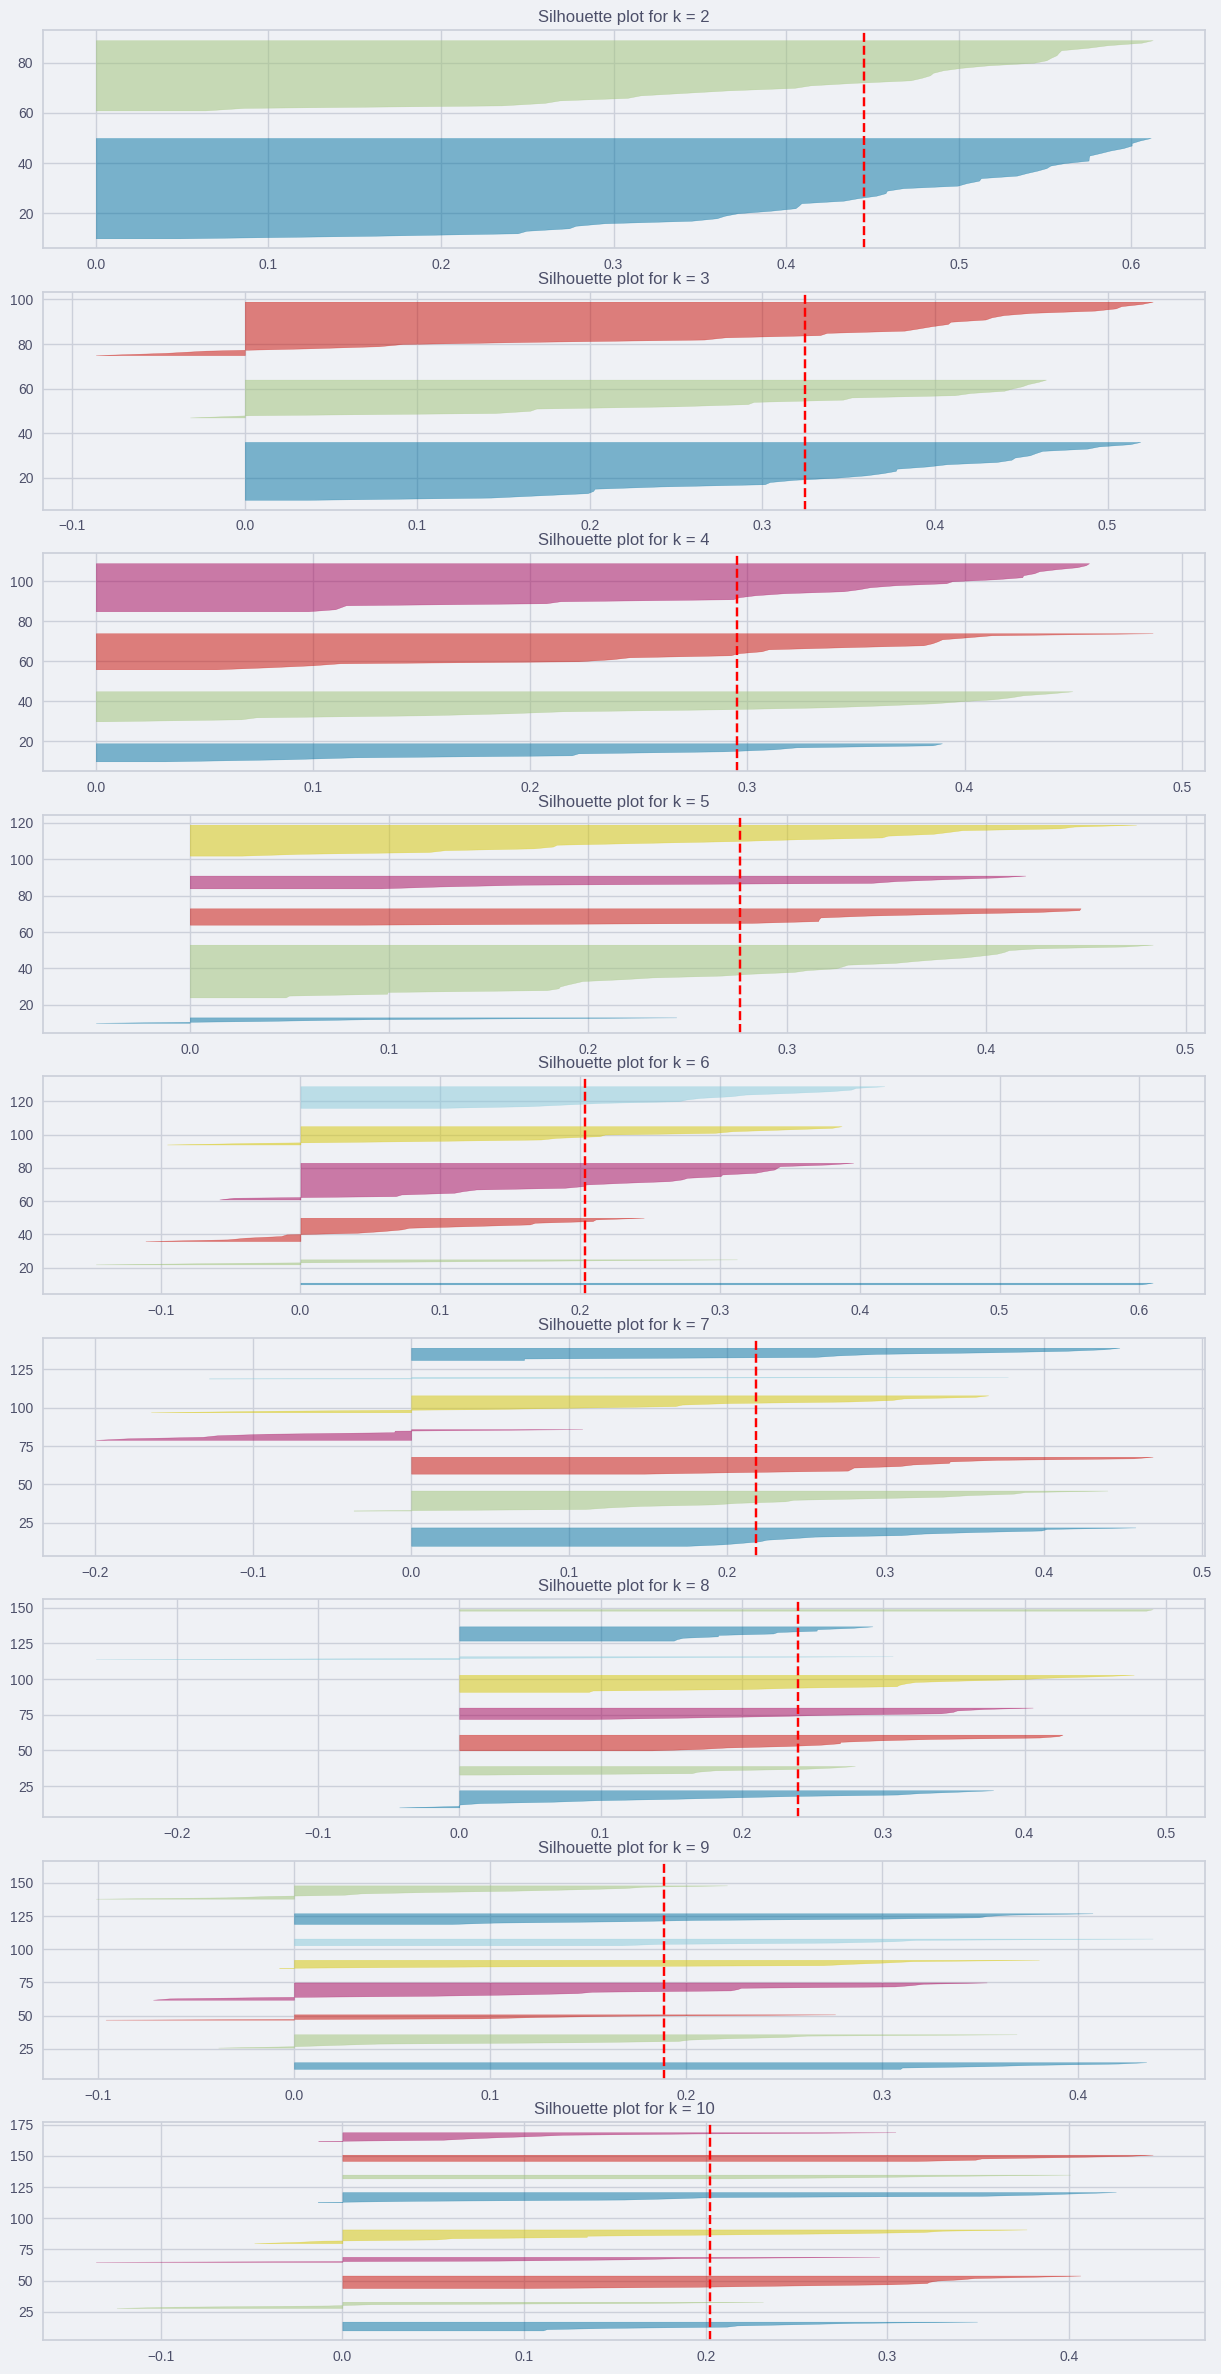

In [58]:
fig, ax = plt.subplots(9,1,figsize=(15, 30))
km.plot_silhouette(ax,[2,3,4,5,6,7,8,9,10])

La méthode du coude semble indiquer 2 ou 3 clusters. Si l'on compare ce résultat à ceux la méthode du coude, nous pouvons aisément valider 3 clusters.

### 3 Clusters 

In [65]:
km.kmean_choose(3)
km.clusters

array([1, 2, 1, 1, 1, 0, 1, 2, 2, 2, 1, 0, 1, 2, 0, 0, 1, 2, 1, 2, 2, 2,
       1, 2, 0, 2, 0, 2, 1, 1, 2, 2, 1, 1, 2, 0, 2, 0, 0, 0, 1, 2, 0, 1,
       0, 0, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 0, 0, 2, 2, 2, 0, 1, 2, 2,
       0, 0, 0, 2], dtype=int32)

In [66]:
df

CO2 emissions (kt)  \
Zone                                      
Afrique du Sud                13.009479   
Algérie                       12.046980   
Allemagne                     13.398015   
Arabie saoudite               13.174522   
Argentine                     12.032689   
...                                 ...   
Ukraine                       12.070258   
Uruguay                        8.825810   
Zambie                         8.938098   
Zimbabwe                       9.228799   
Émirats arabes unis           12.131601   

                     Container port traffic (TEU: 20 foot equivalent units)  \
Zone                                                                          
Afrique du Sud                                               15.326019        
Algérie                                                      14.399953        
Allemagne                                                    16.525533        
Arabie saoudite                                              16.002193        
Argentine                                                    14.421991        
...                                                                ...        
Ukraine                                                      13.822758        
Uruguay                                                      13.527246        
Zambie                                                       14.021778        
Zimbabwe                                                     14.021778        
Émirats arabes unis                                          16.749474        

                     Merchandise exports (current US$)  \
Zone                                                     
Afrique du Sud                               25.223253   
Algérie                                      24.287489   
Allemagne                                    28.029403   
Arabie saoudite                              26.290094   
Argentine                                    24.899436   
...                                                ...   
Ukraine                                      24.636368   
Uruguay                                      22.761885   
Zambie                                       22.674732   
Zimbabwe                                     22.174645   
Émirats arabes unis                          26.687945   

                     Merchandise imports (current US$)  \
Zone                                                     
Afrique du Sud                               25.401119   
Algérie                                      24.521717   
Allemagne                                    27.841264   
Arabie saoudite                              25.754769   
Argentine                                    24.617614   
...                                                ...   
Ukraine                                      24.830856   
Uruguay                                      22.832994   
Zambie                                       22.693590   
Zimbabwe                                     22.295417   
Émirats arabes unis                          26.387777   

                     Rail lines (total route-km)  PIB Valeur US $  \
Zone                                                                
Afrique du Sud                          9.950085        12.769771   
Algérie                                 8.299348        12.050350   
Allemagne                              10.417029        15.173490   
Arabie saoudite                         7.999175        13.583538   
Argentine                               9.790711        13.006832   
...                                          ...              ...   
Ukraine                                 9.981693        11.944257   
Uruguay                                 7.312553        11.022428   
Zambie                                  7.130099        10.056669   
Zimbabwe                                8.045909         9.995888   
Émirats arabes unis                     5.568345        12.941361   

                     Vola

In [67]:
df['cluster']=km.clusters
columns.append('cluster')

In [68]:
df.columns

Index(['CO2 emissions (kt)',
       'Container port traffic (TEU: 20 foot equivalent units)',
       'Merchandise exports (current US$)',
       'Merchandise imports (current US$)', 'Rail lines (total route-km)',
       'PIB Valeur US $', 'Volailles - Production (Milliers de tonnes)',
       'Population urbaine', 'Aliments Volailles (milliers de tonnes)',
       'cluster'],
      dtype='object')

In [69]:
km_df = df.copy() 

In [70]:
km_df

CO2 emissions (kt)  \
Zone                                      
Afrique du Sud                13.009479   
Algérie                       12.046980   
Allemagne                     13.398015   
Arabie saoudite               13.174522   
Argentine                     12.032689   
...                                 ...   
Ukraine                       12.070258   
Uruguay                        8.825810   
Zambie                         8.938098   
Zimbabwe                       9.228799   
Émirats arabes unis           12.131601   

                     Container port traffic (TEU: 20 foot equivalent units)  \
Zone                                                                          
Afrique du Sud                                               15.326019        
Algérie                                                      14.399953        
Allemagne                                                    16.525533        
Arabie saoudite                                              16.002193        
Argentine                                                    14.421991        
...                                                                ...        
Ukraine                                                      13.822758        
Uruguay                                                      13.527246        
Zambie                                                       14.021778        
Zimbabwe                                                     14.021778        
Émirats arabes unis                                          16.749474        

                     Merchandise exports (current US$)  \
Zone                                                     
Afrique du Sud                               25.223253   
Algérie                                      24.287489   
Allemagne                                    28.029403   
Arabie saoudite                              26.290094   
Argentine                                    24.899436   
...                                                ...   
Ukraine                                      24.636368   
Uruguay                                      22.761885   
Zambie                                       22.674732   
Zimbabwe                                     22.174645   
Émirats arabes unis                          26.687945   

                     Merchandise imports (current US$)  \
Zone                                                     
Afrique du Sud                               25.401119   
Algérie                                      24.521717   
Allemagne                                    27.841264   
Arabie saoudite                              25.754769   
Argentine                                    24.617614   
...                                                ...   
Ukraine                                      24.830856   
Uruguay                                      22.832994   
Zambie                                       22.693590   
Zimbabwe                                     22.295417   
Émirats arabes unis                          26.387777   

                     Rail lines (total route-km)  PIB Valeur US $  \
Zone                                                                
Afrique du Sud                          9.950085        12.769771   
Algérie                                 8.299348        12.050350   
Allemagne                              10.417029        15.173490   
Arabie saoudite                         7.999175        13.583538   
Argentine                               9.790711        13.006832   
...                                          ...              ...   
Ukraine                                 9.981693        11.944257   
Uruguay                                 7.312553        11.022428   
Zambie                                  7.130099        10.056669   
Zimbabwe                                8.045909         9.995888   
Émirats arabes unis                     5.568345        12.941361   

                     Vola

In [71]:
cluster0 = km_df[km_df['cluster']==0]
cluster1 = km_df[km_df['cluster']==1]
cluster2 = km_df[km_df['cluster']==2]


In [72]:
cluster0

CO2 emissions (kt)  \
Zone                                    
Arménie                      8.731756   
Botswana                     8.881739   
Burkina Faso                 8.638968   
Cameroun                     9.165165   
Gabon                        8.570829   
Géorgie                      9.263938   
Lettonie                     8.931962   
Luxembourg                   9.159184   
Macédoine du Nord            8.981820   
Madagascar                   8.276064   
Mauritanie                   8.249523   
Mongolie                    10.049659   
Monténégro                   7.864074   
Slovénie                     9.522666   
Soudan                      10.004802   
Tadjikistan                  9.101273   
Uruguay                      8.825810   
Zambie                       8.938098   
Zimbabwe                     9.228799   

                   Container port traffic (TEU: 20 foot equivalent units)  \
Zone                                                                        
Arménie                                                    14.021778        
Botswana                                                   14.021778        
Burkina Faso                                               14.021778        
Cameroun                                                   12.823111        
Gabon                                                      12.170440        
Géorgie                                                    13.307169        
Lettonie                                                   13.016672        
Luxembourg                                                 14.021778        
Macédoine du Nord                                          14.021778        
Madagascar                                                 12.204639        
Mauritanie                                                 11.344021        
Mongolie                                                   14.021778        
Monténégro                                                  9.664304        
Slovénie                                                   13.773647        
Soudan                                                     13.059481        
Tadjikistan                                                14.021778        
Uruguay                                                    13.527246        
Zambie                                                     14.021778        
Zimbabwe                                                   14.021778        

                   Merchandise exports (current US$)  \
Zone                                                   
Arménie                                    21.694045   
Botswana                                   22.379015   
Burkina Faso                               21.898530   
Cameroun                                   22.130343   
Gabon                                      22.628652   
Géorgie                                    22.057740   
Lettonie                                   23.477245   
Luxembourg                                 23.523652   
Macédoine du Nord                          22.695818   
Madagascar                                 21.715035   
Mauritanie                                 21.541282   
Mongolie                                   22.754042   
Monténégro                                 19.957548   
Slovénie                                   24.528661   
Soudan                                     22.041014   
Tadjikistan                                20.883683   
Uruguay                                    22.761885   
Zambie                                     22.674732   
Zimbabwe                                   22.174645   

                   Merchandise imports (current US$)  \
Zone                                                   
Arménie                                    22.430556   
Botswana                                   22.604866   
Burkina Faso                               22.178153   
Cameroun                                   22.607756   
Gabon                     

In [73]:
cluster1

CO2 emissions (kt)  \
Zone                                  
Afrique du Sud            13.009479   
Allemagne                 13.398015   
Arabie saoudite           13.174522   
Argentine                 12.032689   
Australie                 12.887147   
Belgique                  11.440252   
Brésil                    12.981535   
Canada                    13.246354   
Chine                     16.191609   
Espagne                   12.396228   
Inde                      14.700910   
Indonésie                 13.313466   
Italie                    12.667363   
Japon                     13.886571   
Malaisie                  12.408536   
Mexique                   13.021061   
Philippines               11.890487   
Pologne                   12.594559   
Thaïlande                 12.522589   

                 Container port traffic (TEU: 20 foot equivalent units)  \
Zone                                                                      
Afrique du Sud                                           15.326019        
Allemagne                                                16.525533        
Arabie saoudite                                          16.002193        
Argentine                                                14.421991        
Australie                                                15.987511        
Belgique                                                 16.332390        
Brésil                                                   16.186191        
Canada                                                   15.761440        
Chine                                                    19.310874        
Espagne                                                  16.675705        
Inde                                                     16.677004        
Indonésie                                                16.309664        
Italie                                                   16.194069        
Japon                                                    16.962954        
Malaisie                                                 17.081855        
Mexique                                                  15.777558        
Philippines                                              16.031660        
Pologne                                                  14.929499        
Thaïlande                                                16.131041        

                 Merchandise exports (current US$)  \
Zone                                                 
Afrique du Sud                           25.223253   
Allemagne                                28.029403   
Arabie saoudite                          26.290094   
Argentine                                24.899436   
Australie                                26.325403   
Belgique                                 26.825623   
Brésil                                   26.122003   
Canada                                   26.829881   
Chine                                    28.547095   
Espagne                                  26.534461   
Inde                                     26.505058   
Indonésie                                25.845341   
Italie                                   27.010600   
Japon                                    27.282263   
Malaisie                                 26.196356   
Mexique                                  26.855805   
Philippines                              24.976521   
Pologne                                  26.308996   
Thaïlande                                26.229690   

                 Merchandise imports (current US$)  \
Zone                                                 
Afrique du Sud                           25.401119   
Allemagne                                27.841264   
Arabie saoudite                          25.754769   
Argentine                                24.617614   
Australie                                26.123977   
Belgique                                 26.784438   
Brésil                                   25.986795   


In [74]:
cluster2

CO2 emissions (kt)  \
Zone                                      
Algérie                       12.046980   
Autriche                      11.074402   
Azerbaïdjan                   10.477908   
Bangladesh                    11.436541   
Bulgarie                      10.575434   
Chili                         11.428635   
Colombie                      11.279576   
Croatie                        9.712587   
Danemark                      10.298818   
Finlande                      10.621037   
Grèce                         11.001955   
Hongrie                       10.763479   
Irlande                       10.486072   
Israël                        11.047667   
Kazakhstan                    12.228779   
Lituanie                       9.370484   
Maroc                         11.170256   
Nigéria                       11.691449   
Oman                          11.235138   
Ouzbékistan                   11.675799   
Pakistan                      12.123220   
Panama                         9.480436   
Portugal                      10.704720   
Pérou                         10.950336   
Roumanie                      11.211061   
Serbie                        10.737073   
Sri Lanka                     10.061726   
Suisse                        10.528819   
Suède                         10.462120   
Tunisie                       10.343225   
Ukraine                       12.070258   
Émirats arabes unis           12.131601   

                     Container port traffic (TEU: 20 foot equivalent units)  \
Zone                                                                          
Algérie                                                      14.399953        
Autriche                                                     14.021778        
Azerbaïdjan                                                  14.021778        
Bangladesh                                                   14.961617        
Bulgarie                                                     12.475852        
Chili                                                        15.351751        
Colombie                                                     15.278040        
Croatie                                                      12.761210        
Danemark                                                     13.687723        
Finlande                                                     14.302968        
Grèce                                                        15.632543        
Hongrie                                                      14.021778        
Irlande                                                      13.877067        
Israël                                                       14.886067        
Kazakhstan                                                   14.021778        
Lituanie                                                     13.463114        
Maroc                                                        15.618672        
Nigéria                                                      14.302336        
Oman                                                         15.402799        
Ouzbékistan                                                  14.021778        
Pakistan                                                     14.962913        
Panama                                                       15.809784        
Portugal                                                     14.881630        
Pérou                                                        14.800297        
Roumanie                                                     13.409101        
Serbie                                                       14.021778        
Sri Lanka                                                    15.793750        
Suisse                                                       11.706574        
Suède                                                        14.300011        
Tunisie                                                      13.069433        
Ukraine                       

Afin d'y voir plus claire, représentons nos données avec un boxplot :

Text(0.5, 0.98, 'Boxplot by clusters for each features')

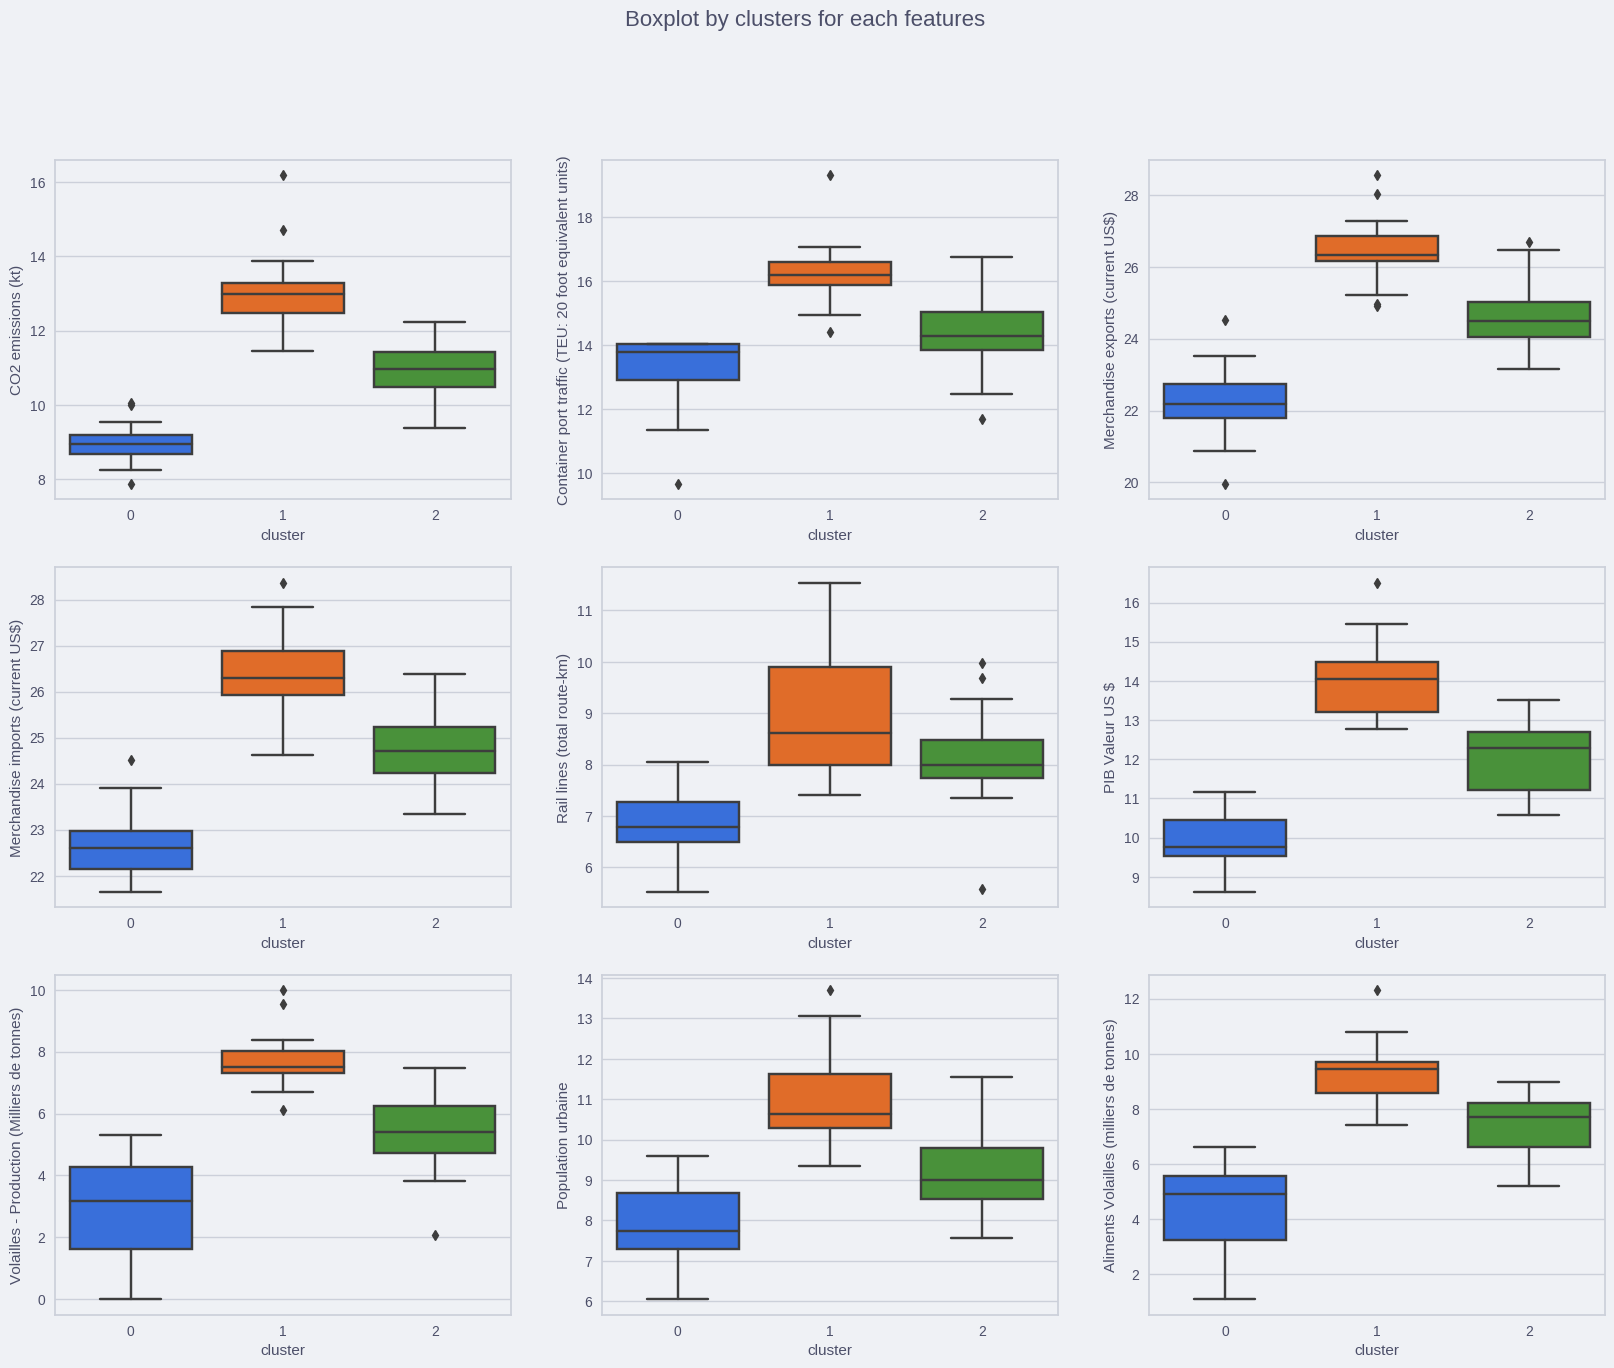

In [75]:
# box plot by clusters for each feature
fig, ax = plt.subplots(3,3,figsize=(20, 15))
sns.boxplot(x="cluster", y="CO2 emissions (kt)", data=km_df, ax=ax[0,0])
sns.boxplot(x="cluster", y="Container port traffic (TEU: 20 foot equivalent units)", data=km_df, ax=ax[0,1])
sns.boxplot(x="cluster", y="Merchandise exports (current US$)", data=km_df, ax=ax[0,2])
sns.boxplot(x="cluster", y="Merchandise imports (current US$)", data=km_df, ax=ax[1,0])
sns.boxplot(x="cluster", y="Rail lines (total route-km)", data=km_df, ax=ax[1,1])
sns.boxplot(x="cluster", y="PIB Valeur US $", data=km_df, ax=ax[1,2])
sns.boxplot(x="cluster", y="Volailles - Production (Milliers de tonnes)", data=km_df, ax=ax[2,0])
sns.boxplot(x="cluster", y="Population urbaine", data=km_df, ax=ax[2,1])
sns.boxplot(x="cluster", y="Aliments Volailles (milliers de tonnes)", data=km_df, ax=ax[2,2])
fig.suptitle('Boxplot by clusters for each features', fontsize=16)

Les pays du cluster 1 sont un groupe de pays riches : PIB élevé, Imports/Exports élevés, transport maritime et féroviaire développé et population urbaine très élevée.
En ce qui concerne la volaille, ceux-ci ont la production la plus élevé ainsi qu'une quantité d'alimentation dédiée à l'élevage de volaille la plus importante. Sur ces deux points en particulier, les boites sont très resséré, ce qui traduit une variance faible. Il faut toutefois noter la présence d'outliers dans cluster !! Par ailleurs, ils sont aussi les pays qui polluent le plus.

Le cluster 2 quant à lui montre des pays légèrement plus pauvres : le transport de marchandise y est moins dévelopé, la population urbaine moins importantes. La production de volaille y est plus faible (médiane du cluster 1 : ~7.8 Milliers de tonnes, médiane du cluster 2 : ~5.8 Milliers de tonnes) et la quantité d'alimentation dédiée à l'élevage de volaille y est aussi plus faible. Ces deux variables observent une variance légèrement plus élevée que dans le cluster 1. Enfin, ces pays polluent moins.

Le cluster 0 est le moins intéressant de tous. Il s'agit globalement des pays les plus pauvres. Surtout, la variance observée sur la production de volaille et l'alimentation des volaille y est relativement élevée.

Le cluster 1 a production de volaille y est déjà très élevé, les matières premières nécessaires sont aussi disponibles. En revanche, il est probablement le cluster où la concurrance y est la plus forte.

Le cluster 2 est une bonne alternative, le production y est aussi élevé, les matières premières nécessaires sont aussi disponibles. La concurrence y est sans doute plus faible.


Enelevons nos outliers au cluster 1 :

In [76]:
cluster1_filtered = cluster1.copy()
cluster1_filtered = cluster1_filtered[['Volailles - Production (Milliers de tonnes)']]
Q1 = cluster1_filtered.quantile(0.25)
Q3 = cluster1_filtered.quantile(0.75)
IQR = Q3 - Q1
threshold = 1.5
lower_bound = Q1 - (threshold * IQR)
upper_bound = Q3 + (threshold * IQR)
cluster1_filtered = cluster1_filtered[(cluster1_filtered['Volailles - Production (Milliers de tonnes)'] <= upper_bound[0]) & (cluster1_filtered['Volailles - Production (Milliers de tonnes)'] >= lower_bound[0])]
cluster1_filtered = cluster1_filtered.drop(['Volailles - Production (Milliers de tonnes)'], axis=1)
cluster1_filtered.merge(cluster1, how='left', left_index=True, right_index=True)

CO2 emissions (kt)  \
Zone                                  
Afrique du Sud            13.009479   
Allemagne                 13.398015   
Arabie saoudite           13.174522   
Argentine                 12.032689   
Australie                 12.887147   
Canada                    13.246354   
Espagne                   12.396228   
Inde                      14.700910   
Indonésie                 13.313466   
Italie                    12.667363   
Japon                     13.886571   
Malaisie                  12.408536   
Mexique                   13.021061   
Philippines               11.890487   
Pologne                   12.594559   
Thaïlande                 12.522589   

                 Container port traffic (TEU: 20 foot equivalent units)  \
Zone                                                                      
Afrique du Sud                                           15.326019        
Allemagne                                                16.525533        
Arabie saoudite                                          16.002193        
Argentine                                                14.421991        
Australie                                                15.987511        
Canada                                                   15.761440        
Espagne                                                  16.675705        
Inde                                                     16.677004        
Indonésie                                                16.309664        
Italie                                                   16.194069        
Japon                                                    16.962954        
Malaisie                                                 17.081855        
Mexique                                                  15.777558        
Philippines                                              16.031660        
Pologne                                                  14.929499        
Thaïlande                                                16.131041        

                 Merchandise exports (current US$)  \
Zone                                                 
Afrique du Sud                           25.223253   
Allemagne                                28.029403   
Arabie saoudite                          26.290094   
Argentine                                24.899436   
Australie                                26.325403   
Canada                                   26.829881   
Espagne                                  26.534461   
Inde                                     26.505058   
Indonésie                                25.845341   
Italie                                   27.010600   
Japon                                    27.282263   
Malaisie                                 26.196356   
Mexique                                  26.855805   
Philippines                              24.976521   
Pologne                                  26.308996   
Thaïlande                                26.229690   

                 Merchandise imports (current US$)  \
Zone                                                 
Afrique du Sud                           25.401119   
Allemagne                                27.841264   
Arabie saoudite                          25.754769   
Argentine                                24.617614   
Australie                                26.123977   
Canada                                   26.860978   
Espagne                                  26.644174   
Inde                                     26.909596   
Indonésie                                25.866542   
Italie                                   26.886593   
Japon                                    27.303845   
Malaisie                                 26.046266   
Mexique                                  26.869848   
Philippines                              25.449848   
Pologne                                  26.304059   
Thaïlande                                26.188199   

                 

In [77]:
cluster2

CO2 emissions (kt)  \
Zone                                      
Algérie                       12.046980   
Autriche                      11.074402   
Azerbaïdjan                   10.477908   
Bangladesh                    11.436541   
Bulgarie                      10.575434   
Chili                         11.428635   
Colombie                      11.279576   
Croatie                        9.712587   
Danemark                      10.298818   
Finlande                      10.621037   
Grèce                         11.001955   
Hongrie                       10.763479   
Irlande                       10.486072   
Israël                        11.047667   
Kazakhstan                    12.228779   
Lituanie                       9.370484   
Maroc                         11.170256   
Nigéria                       11.691449   
Oman                          11.235138   
Ouzbékistan                   11.675799   
Pakistan                      12.123220   
Panama                         9.480436   
Portugal                      10.704720   
Pérou                         10.950336   
Roumanie                      11.211061   
Serbie                        10.737073   
Sri Lanka                     10.061726   
Suisse                        10.528819   
Suède                         10.462120   
Tunisie                       10.343225   
Ukraine                       12.070258   
Émirats arabes unis           12.131601   

                     Container port traffic (TEU: 20 foot equivalent units)  \
Zone                                                                          
Algérie                                                      14.399953        
Autriche                                                     14.021778        
Azerbaïdjan                                                  14.021778        
Bangladesh                                                   14.961617        
Bulgarie                                                     12.475852        
Chili                                                        15.351751        
Colombie                                                     15.278040        
Croatie                                                      12.761210        
Danemark                                                     13.687723        
Finlande                                                     14.302968        
Grèce                                                        15.632543        
Hongrie                                                      14.021778        
Irlande                                                      13.877067        
Israël                                                       14.886067        
Kazakhstan                                                   14.021778        
Lituanie                                                     13.463114        
Maroc                                                        15.618672        
Nigéria                                                      14.302336        
Oman                                                         15.402799        
Ouzbékistan                                                  14.021778        
Pakistan                                                     14.962913        
Panama                                                       15.809784        
Portugal                                                     14.881630        
Pérou                                                        14.800297        
Roumanie                                                     13.409101        
Serbie                                                       14.021778        
Sri Lanka                                                    15.793750        
Suisse                                                       11.706574        
Suède                                                        14.300011        
Tunisie                                                      13.069433        
Ukraine                       

#### Projection des individus sur F1 et F2

/tmp/ipykernel_690285/2549751352.py:144: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())


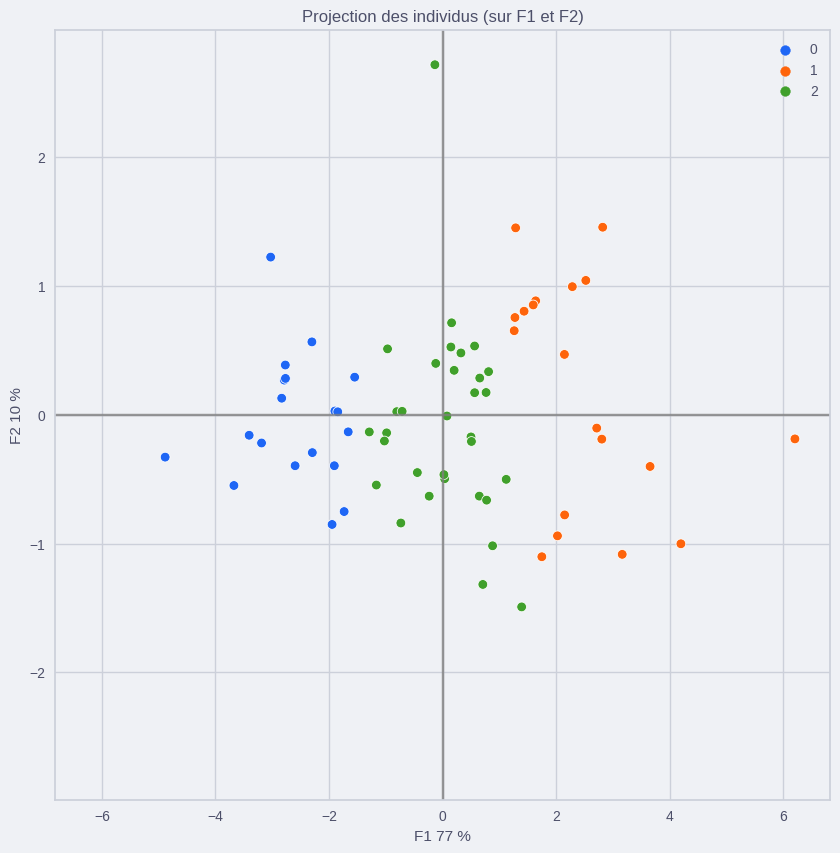

In [78]:
fp1, ax = plt.subplots(figsize=(10, 10))
pca2.display_factorial_planesi(ax,(0,1), clusters=km.clusters)

# Conclusion

En conclusion, l'analyse des clusters basée sur la transformation des données à l'aide de la fonction log(x+1) a permis de mettre en évidence trois groupes distincts de pays en fonction de leurs caractéristiques économiques, environnementales et de production de volaille.

Le cluster 1 regroupe des pays riches avec des indicateurs économiques solides tels qu'un PIB élevé, des importations et exportations substantielles, ainsi qu'une infrastructure de transport développée. Ces pays présentent également une forte production de volaille et une allocation significative d'aliments pour l'élevage. Cependant, cette concentration élevée dans la production de volaille pourrait engendrer une concurrence intense malgré les conditions favorables.

Le cluster 2 comprend des pays légèrement moins riches que ceux du cluster 1, avec des indicateurs économiques comparativement moins élevés. Malgré cela, ces pays affichent toujours une production de volaille considérable et une quantité significative d'aliments allouée à l'élevage. La concurrence dans ce cluster pourrait être moins intense par rapport au cluster 1, ce qui en fait une alternative viable pour les activités avicoles.

Enfin, le cluster 0, composé des pays les moins développés économiquement, présente une variabilité élevée dans la production de volaille et l'alimentation des volailles. Cette diversité peut refléter des conditions économiques et environnementales moins stables, ce qui pourrait rendre les investissements dans la production de volaille plus risqués dans ce groupe.

Il est important de noter que malgré les avantages économiques du cluster 1 et 2, ils ont également des émissions de CO2 plus élevées, soulignant le besoin d'adopter des pratiques plus durables pour réduire l'impact environnemental.

En définitive, cette analyse de clustering offre des perspectives précieuses pour les investissements dans la production de volaille, en prenant en compte les caractéristiques économiques, environnementales et de production spécifiques à chaque groupe de pays. Cependant, pour des décisions plus éclairées, il est essentiel de considérer d'autres facteurs tels que les réglementations locales, les pratiques agricoles et les préoccupations environnementales croissantes.